In [32]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from urllib.request import urlopen
from numpy.linalg import norm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

### Loading Data

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i % 500000 == 0: print(i)
    return pd.DataFrame.from_dict(df, orient='index')

#### review

In [5]:
print("Start loading review data")
review_data = getDF(r'C:\Users\Xylon\Desktop\data200_grad\data\Toys_and_Games.json.gz')
print("Finish loading review data")

# total length of list, this number equals total number of products
print(len(review_data))

Start loading review data
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
Finish loading review data
8201231


#### metadata

In [6]:
print("Start loading meta data")
meta_data = getDF(r'C:\Users\Xylon\Desktop\data200_grad\data\meta_Toys_and_Games.json.gz')
print("Finish loading meta data")
# total length of list, this number equals total number of products
print(len(meta_data))

Start loading meta data
500000
Finish loading meta data
633883


### Data Preprocessing

#### review

Drop useless columns. 

In [7]:
review_data = review_data.drop(columns=['image', 'style'])

Technically, a user can only make 1 review at a reviewTime for a product. Therefore, we remove the duplicates which share the same reviewerID, product asin, and unixReviewTime.

In [8]:
review_data.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)

Fill in 0 and " " for NaN values in 'vote', 'reviewText', and 'summary'. Drop the remaining NaN values.

In [9]:
review_data['vote'] = review_data['vote'].str.replace(',', '').fillna(0).astype('int')

In [10]:
review_data['reviewText'] = review_data['reviewText'].fillna('')
review_data['summary'] = review_data['summary'].fillna('')

In [11]:
review_data = review_data.dropna()

In [12]:
print(len(review_data))

8002086


Convert "reviewTime" from string to datetime object. Extract year.

In [13]:
review_data = review_data[review_data.reviewTime.str.match(r"\d{2} \d{1,2}, \d{4}")]
review_data['reviewTime'] = pd.to_datetime(review_data['reviewTime'],format='%m %d, %Y', errors='coerce')
review_data['reviewYear'] = pd.DatetimeIndex(review_data['reviewTime']).year

Count the word-level length of "reviewText".

In [14]:
review_data['review_length'] = review_data['reviewText'].str.count(" ")+1

Convert numpy boolean to int (0 and 1) for the "verified" column.

In [15]:
review_data['verified'] = review_data['verified'].astype('int')

In [16]:
review_data.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewYear,review_length
0,2.0,12,0,2016-09-22,A1IDMI31WEANAF,0020232233,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,2016,80
1,1.0,21,0,2016-09-18,A4BCEVVZ4Y3V3,0020232233,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,2016,125
2,3.0,19,1,2016-09-12,A2EZ9PY1IHHBX0,0020232233,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,2016,257
3,5.0,0,1,2017-03-02,A139PXTTC2LGHZ,0020232233,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,2017,14
4,1.0,3,1,2017-02-08,A3IB33V29XIL8O,0020232233,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,2017,25


#### metadata

Extract useful columns and filter out 'price' with the desired format.

In [17]:
meta_data = meta_data[['price', 'asin']]

In [18]:
meta_data = meta_data[meta_data['price'].str.match(r'\$[0-9]*.[0-9]*')]
meta_data['price'] = meta_data['price'].str.extract(r'\$(.*)')
meta_data['price'] = pd.to_numeric(meta_data['price'],errors='coerce')

In [19]:
meta_data = meta_data.dropna()
print(len(meta_data))

314276


In [20]:
meta_data.head(5)

,price,asin
3,24.95,0004983289
4,4.92,0006466222
5,13.50,0020232233
9,35.09,019848710X
10,28.81,0198487126


#### Merged data

In [21]:
all_data = pd.merge(review_data, meta_data, on="asin")
all_data = all_data[['review_length', 'reviewYear', 'overall', 'price']]

In [22]:
len(all_data)

5628873

### Exploratory Data Analysis

#### Distribution of review over years
From the bar plot below, we can observe that the number of reviews generally increased from 1999 to 2016 as online shopping became more and more popular during that period. After reached its peak, the number of reviews started to decrease from 2016 to 2018. This decline might be due to the fact that Amazon banned incentivized reviews in October of 2016, followed by top reviewers being kicked off the platform if Amazon suspected that they were not complying with the changes.

Text(0.5, 0, 'Year')

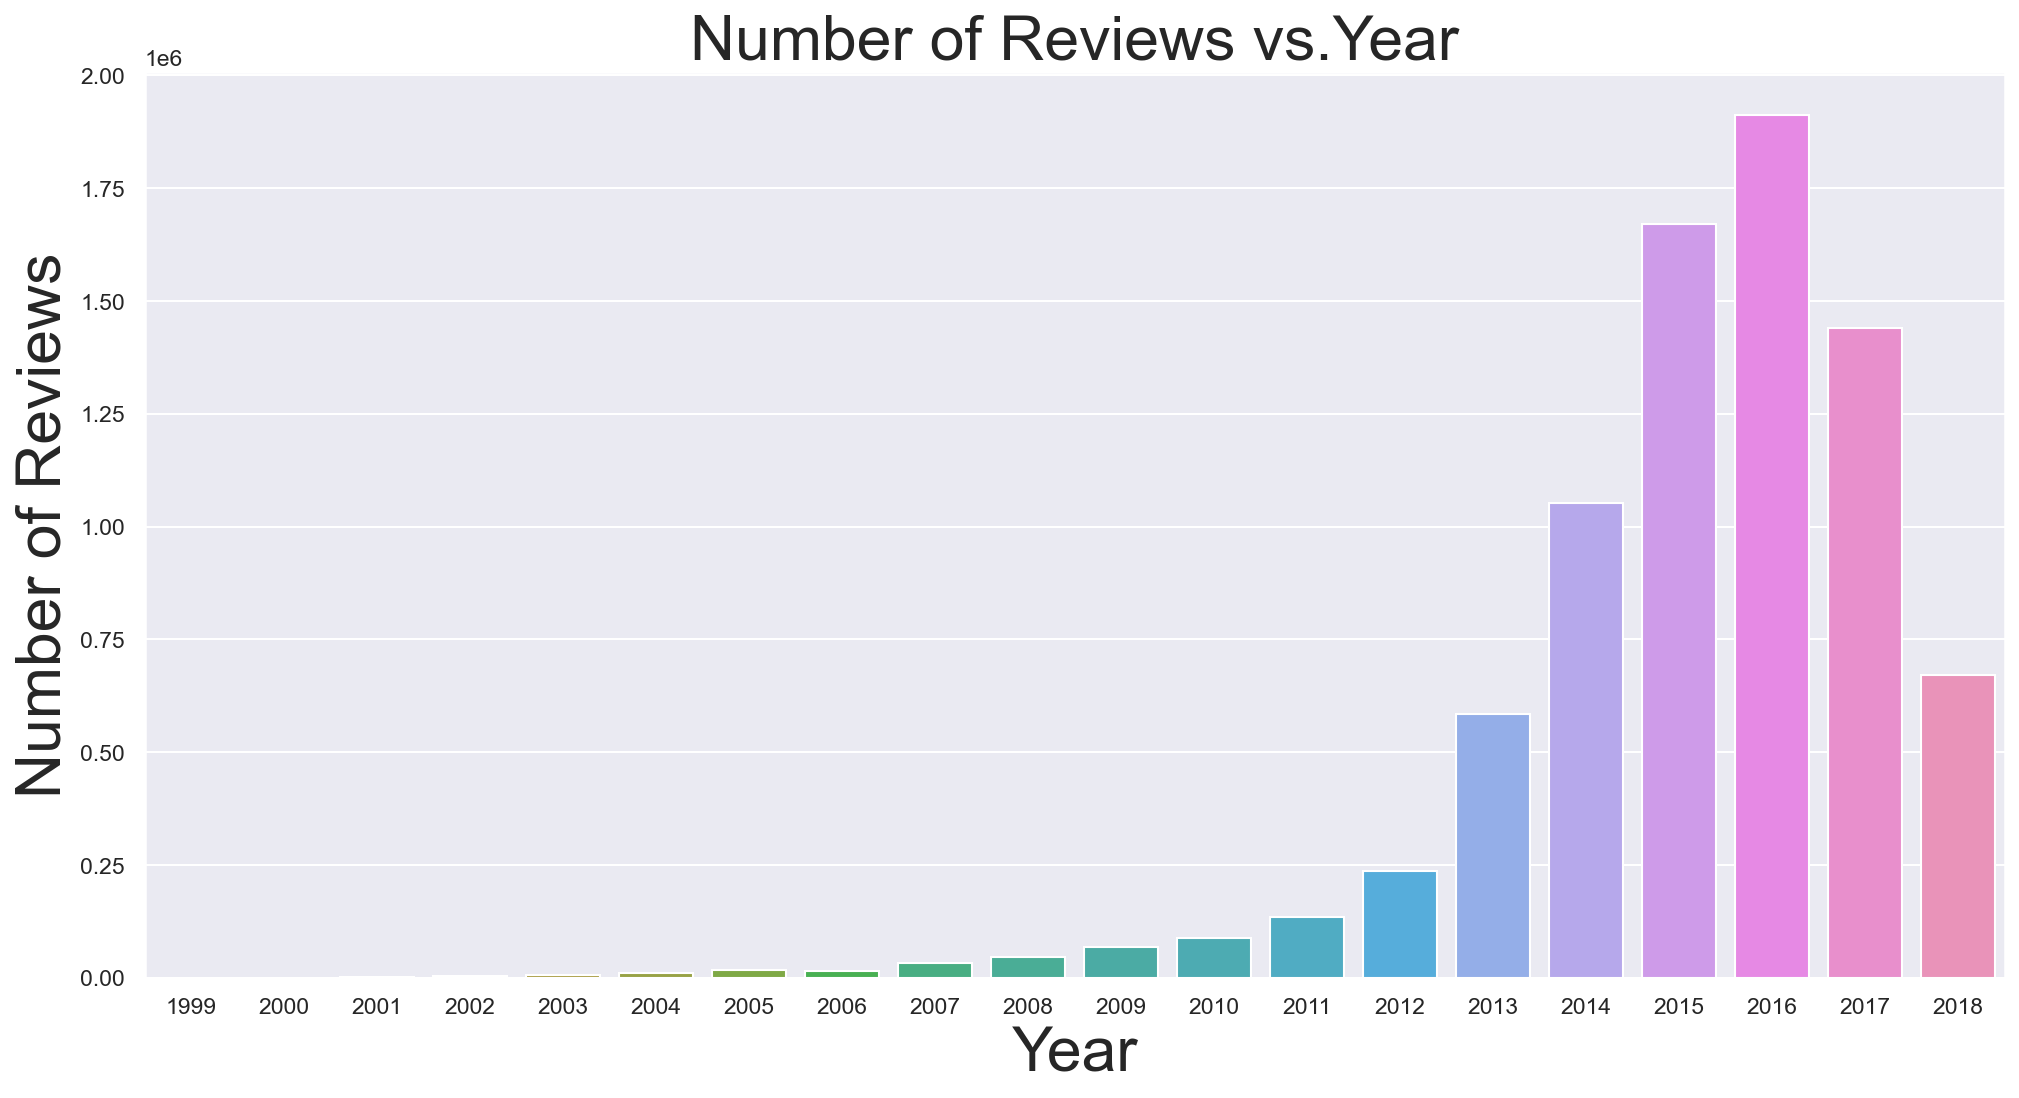

In [34]:
# sort dataframe by year for plotting purpose
review_df_sorted_by_year = review_data.sort_values("reviewYear")
# plot
ax = sns.countplot(x="reviewYear", data=review_df_sorted_by_year)
ax.set_title("Number of Reviews vs.Year", fontsize=30)
ax.set_ylabel("Number of Reviews",fontsize=30)
ax.set_xlabel("Year", fontsize=30)

#### Distribution for length of reviews

From the histgram below, as we did data preprocessing to split reviews to seperate words, we can observe that for most of reviews, the length of it is shorter than 100 words. We have arounf 800,000 reviews in total, the number of reviews which is shorter than 50 words is over 600,000. This part of data can be a useful and reasonable subset for the whole meta data. And all the reviews have the similar length can make our recommendatoin more accuarate.

In [22]:
review_data['review_length'].describe()

count    8.002086e+06
mean     3.677851e+01
std      5.733462e+01
min      1.000000e+00
25%      8.000000e+00
50%      2.100000e+01
75%      4.300000e+01
max      5.745000e+03
Name: review_length, dtype: float64

Text(0, 0.5, 'Number of reviews')

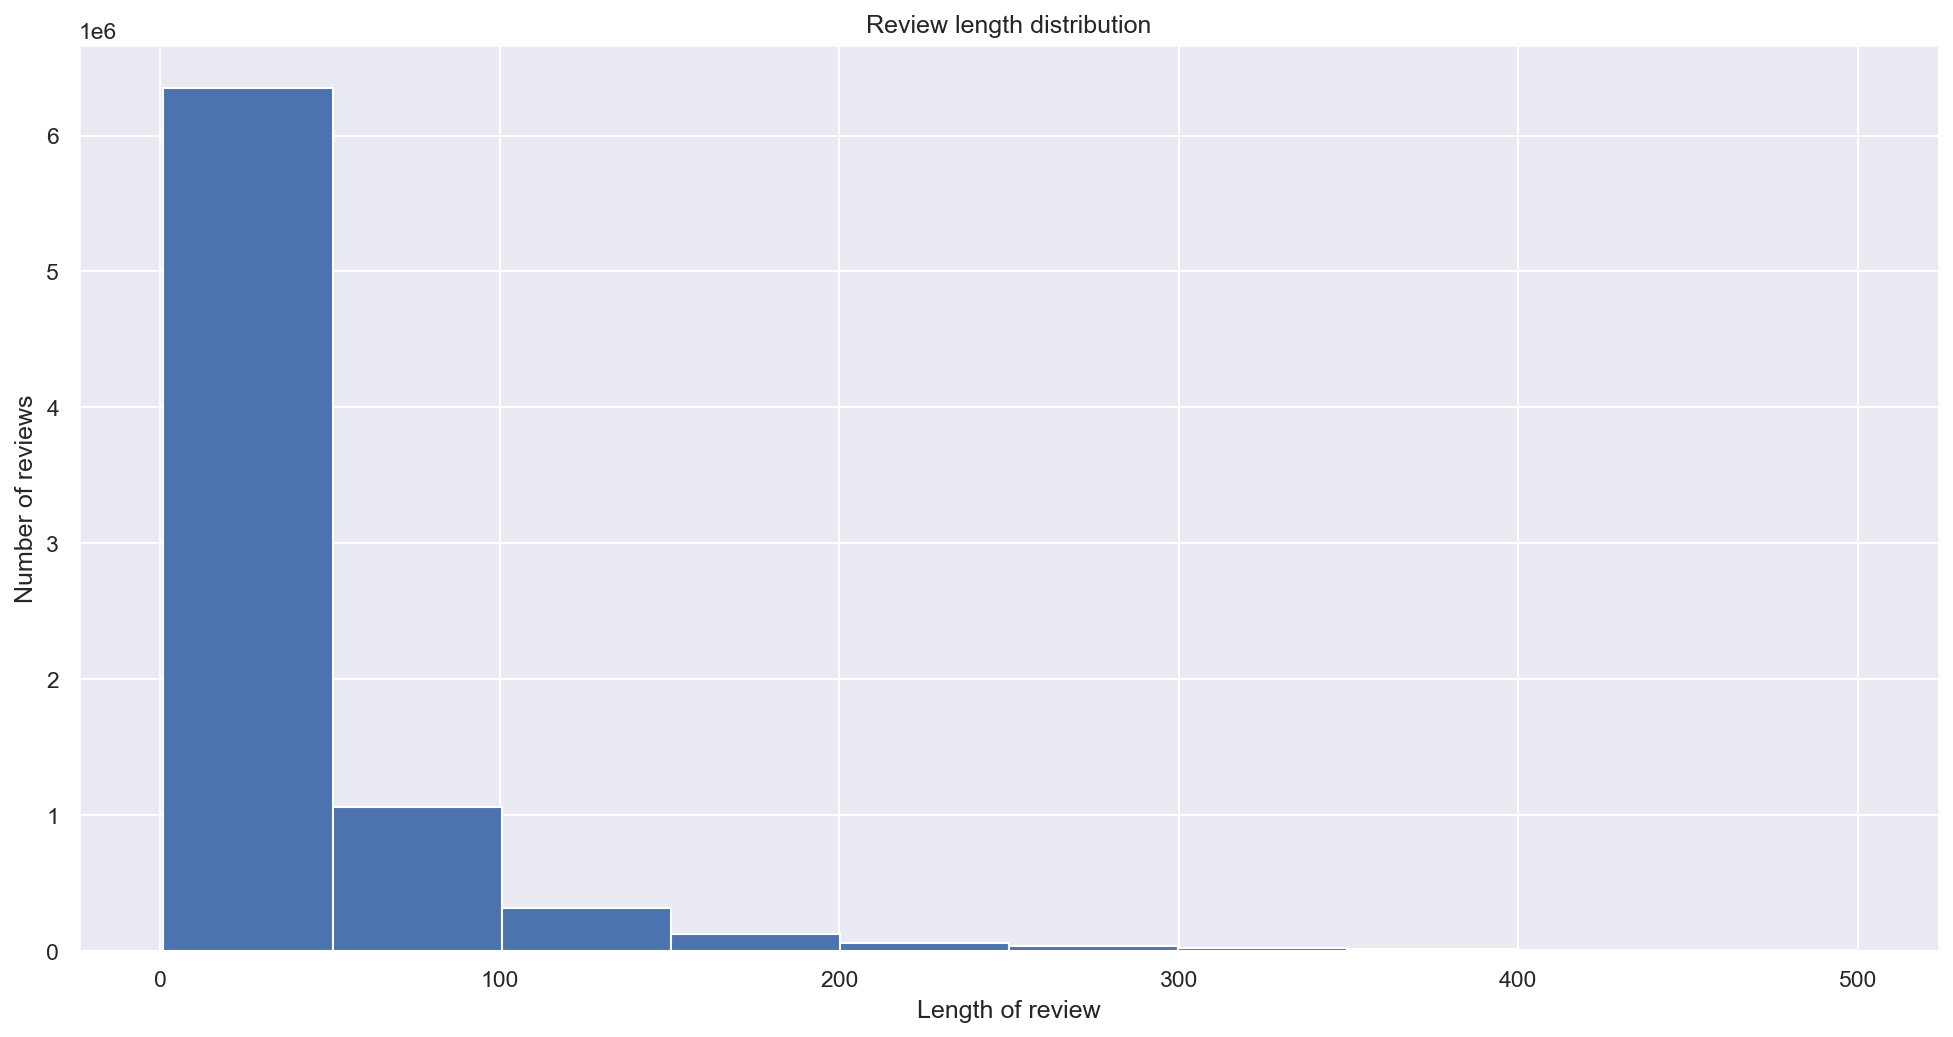

In [23]:
review_data_mask = review_data[review_data['review_length'] < 500]
plt.hist(review_data_mask['review_length'])
plt.title('Review length distribution')
plt.xlabel('Length of review')
plt.ylabel('Number of reviews')

#### Distribution of product price 

Though we have the highest product price for 999.99 dollar and cheapest product for 0.01 dollar, we can observe from the histgram that the price of majority products are below 200 dollar. We have 314,276 sample in total, and there are almost 300,000 of it have a price in range 0 to 50. When the product price rising high, the number of purchase decreasing greatly. 

In [24]:
meta_data['price'].describe()

count    314276.000000
mean         31.862147
std          56.474806
min           0.010000
25%           8.730000
50%          15.990000
75%          32.640000
max         999.990000
Name: price, dtype: float64

Text(0, 0.5, 'Number of product')

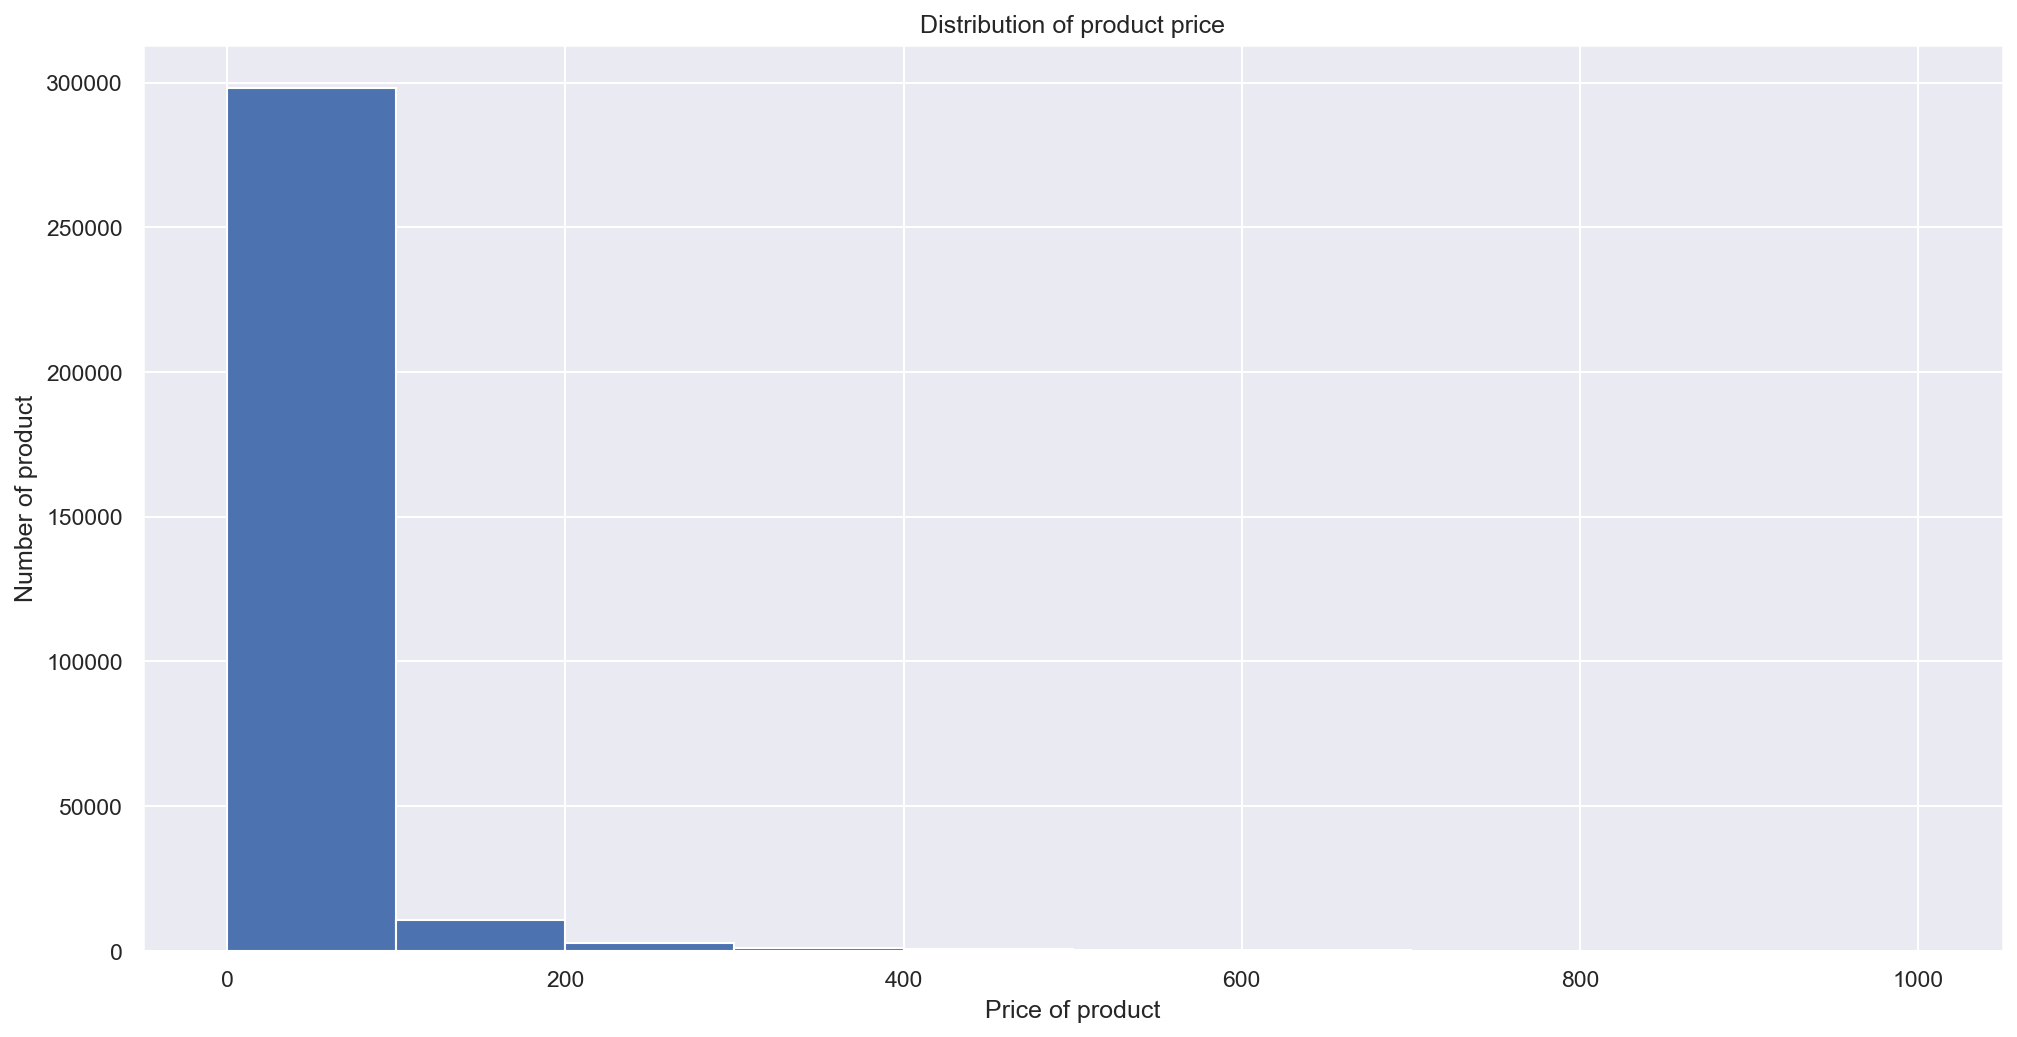

In [25]:
plt.hist(meta_data['price'])
plt.title('Distribution of product price')
plt.xlabel('Price of product')
plt.ylabel('Number of purchases')

#### Distribution between product's price and the overall rank of the product
From the box plot, we could find the quantiles and median value of price don't change too much with the change in the product's overall rank. Therefore, it seems like there is little correlation between the product's price and the overall rank of the product.

In [26]:
all_data.price.describe()

count    5.628873e+06
mean     3.207152e+01
std      5.211283e+01
min      1.000000e-02
25%      9.990000e+00
50%      1.787000e+01
75%      3.299000e+01
max      9.999900e+02
Name: price, dtype: float64

Text(0.5, 0, 'overall rank')

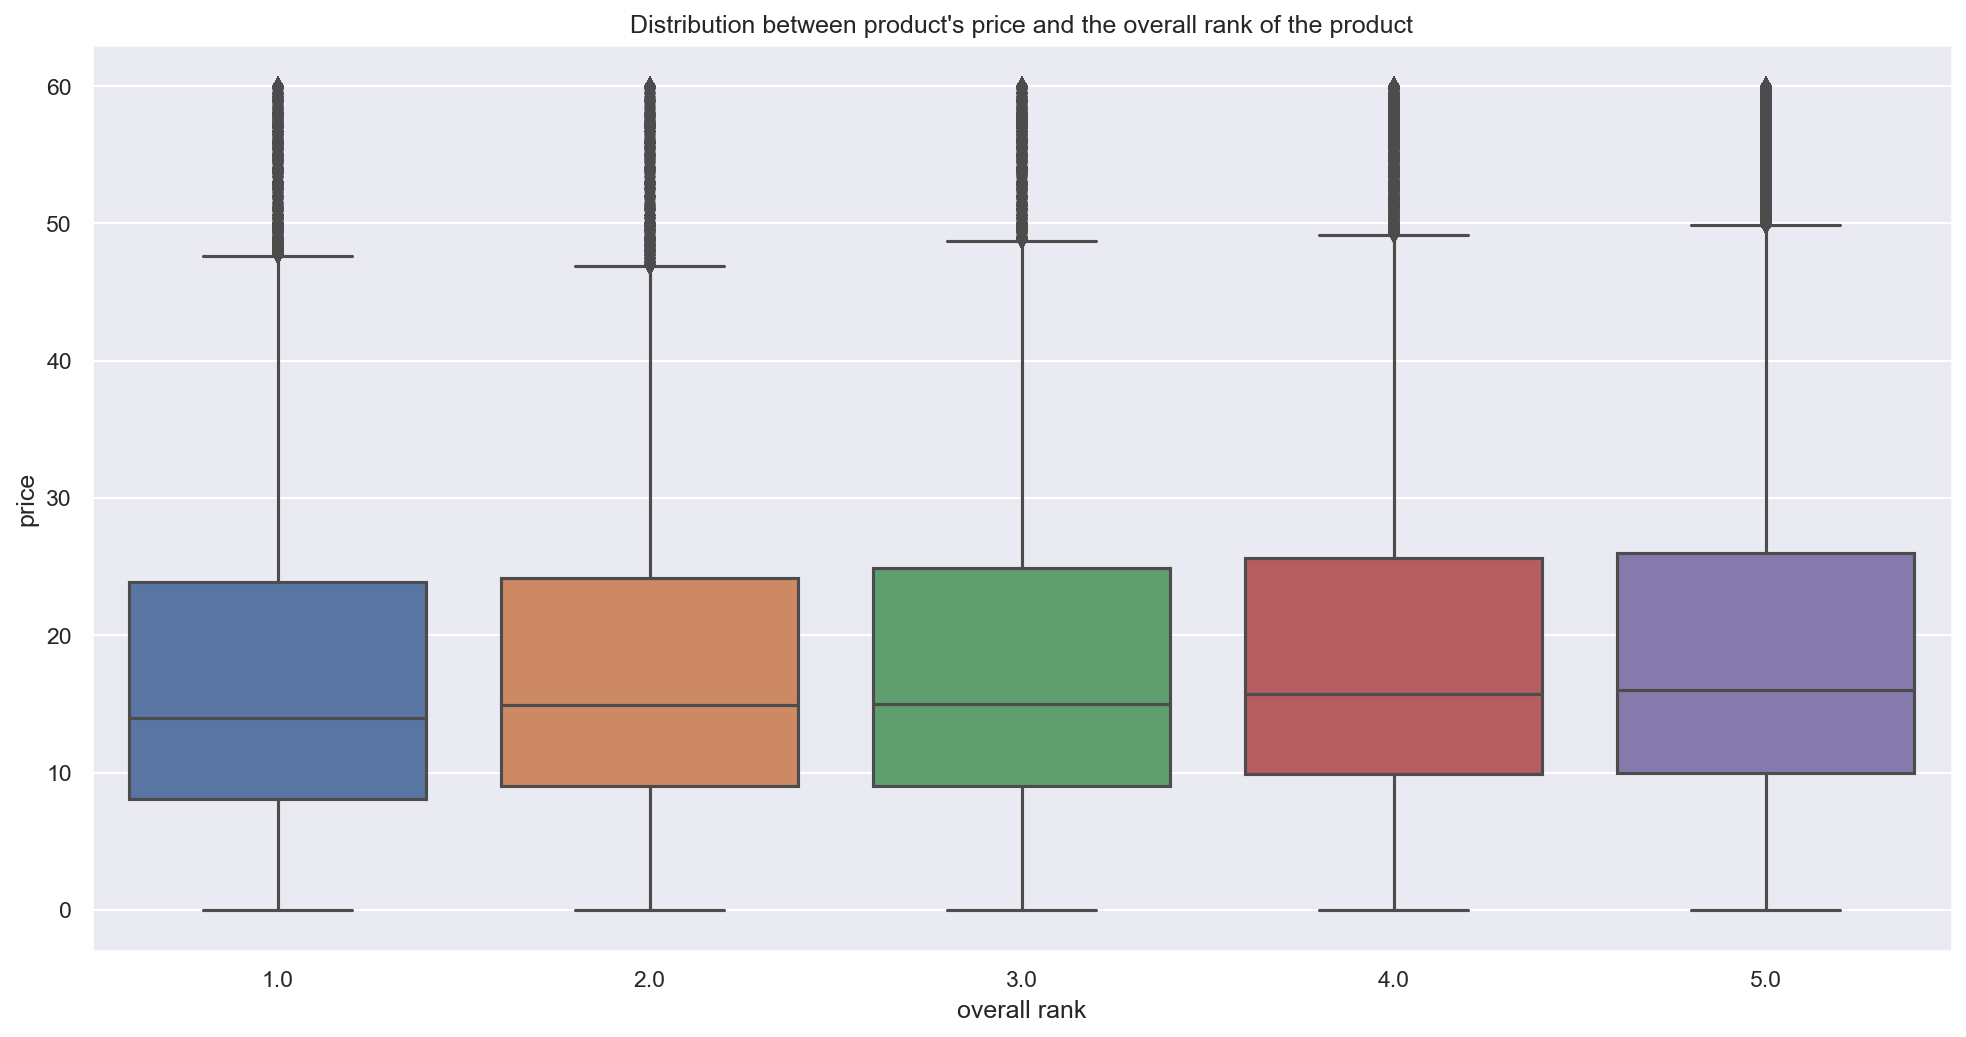

In [27]:
ax = sns.boxplot(x="overall", y="price", data=all_data[all_data['price'] < 60])
ax.set_title("Distribution between product's price and the overall rank of the product")
ax.set_xlabel('overall rank')

#### Distribution between product's review length and the overall rank of the product
From the box plot, we can find that starting from the overall rank being 2, the median value of review length starts to decrease with the increase of overall rank. The median value and quantiles of review length are the largest when the overall rank is 2.

In [28]:
review_data.review_length.describe()

count    8.002086e+06
mean     3.677851e+01
std      5.733462e+01
min      1.000000e+00
25%      8.000000e+00
50%      2.100000e+01
75%      4.300000e+01
max      5.745000e+03
Name: review_length, dtype: float64

Text(0, 0.5, 'review length')

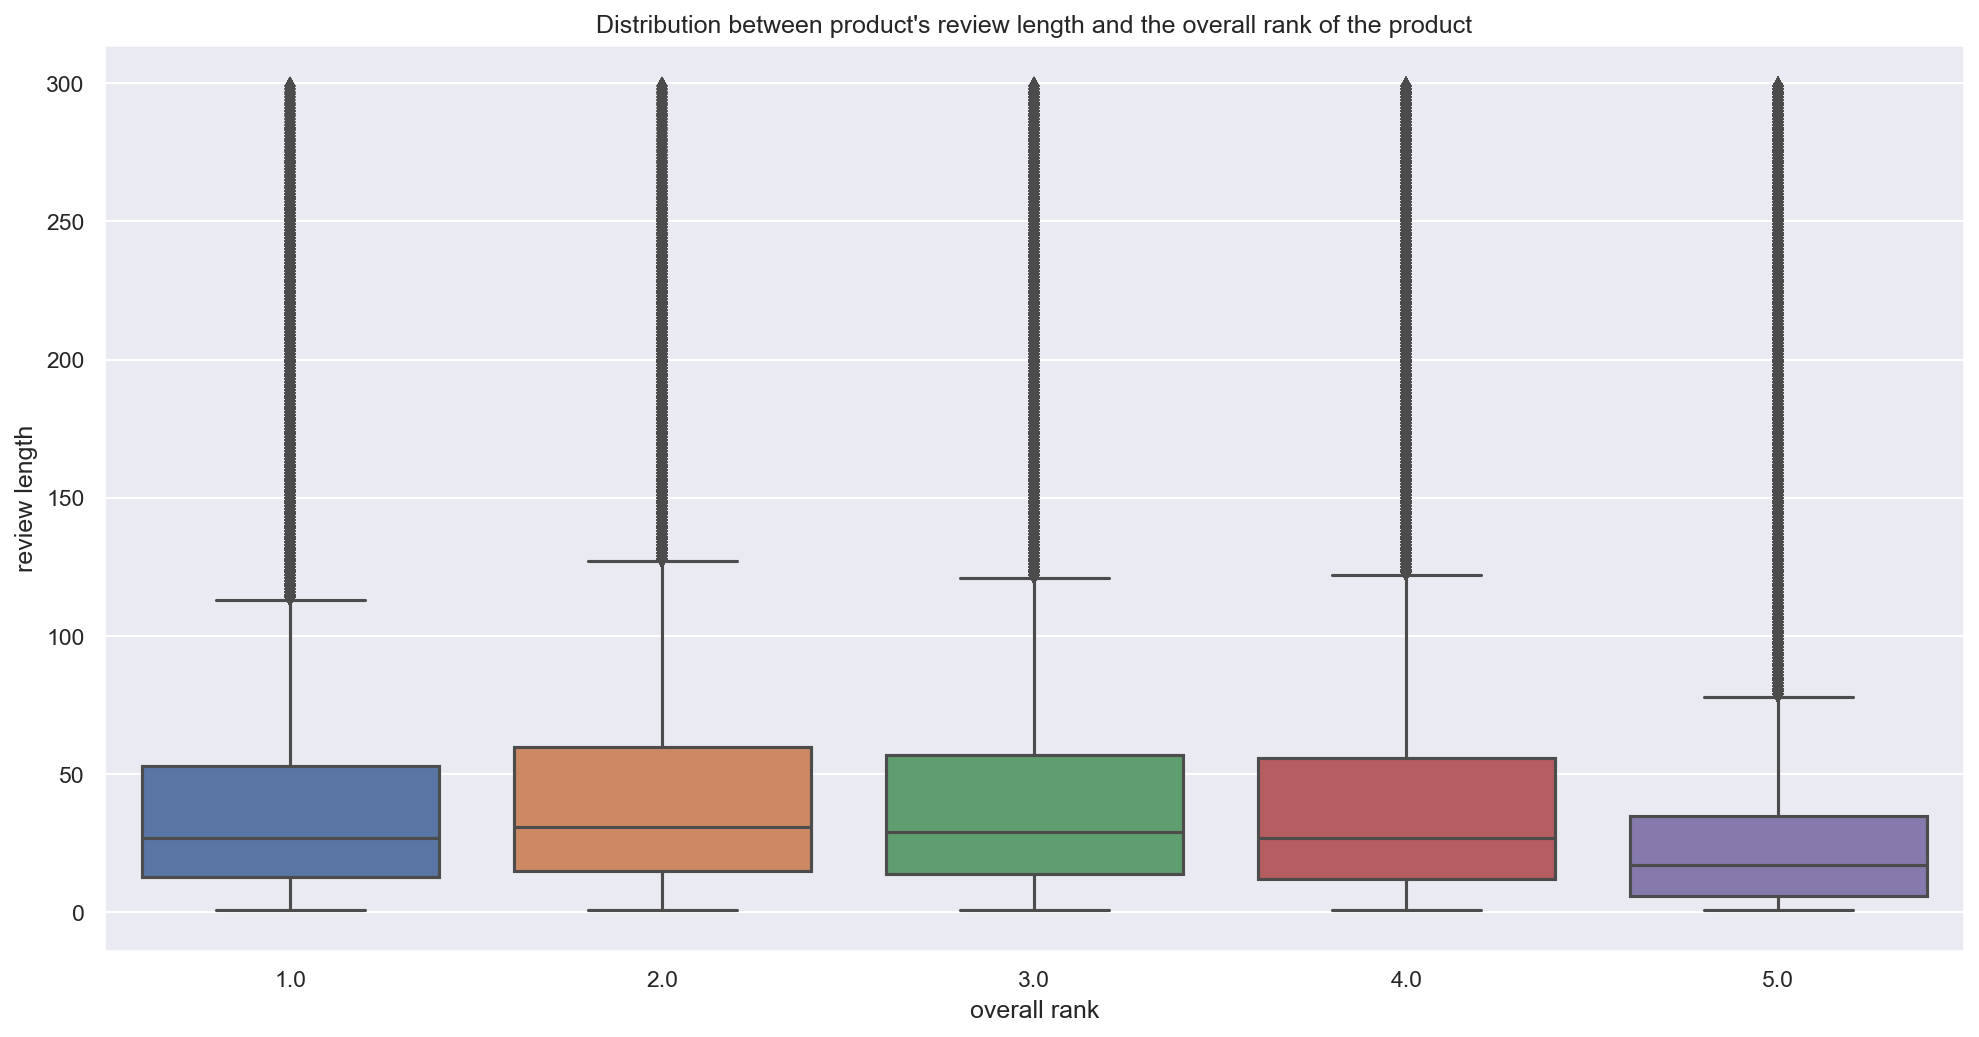

In [29]:
ax = sns.boxplot(x="overall", y="review_length", data=review_data[review_data['review_length']<300])
ax.set_title("Distribution between product's review length and the overall rank of the product")
ax.set_xlabel('overall rank')
ax.set_ylabel('review length')

#### Average of product's overall rank vs. year of the product's review
From the line plot, we could find that the mean value of overall rank decreases from the year 2000 to 2005 and generally increase from 2005 to 2017. The mean value of overall rank is lowest in the year 2005, which is quite interesting. This might be due to the reason that the number of reviews before 2006 is too small, so the data is not that precise.

Text(0.5, 0, 'year of review')

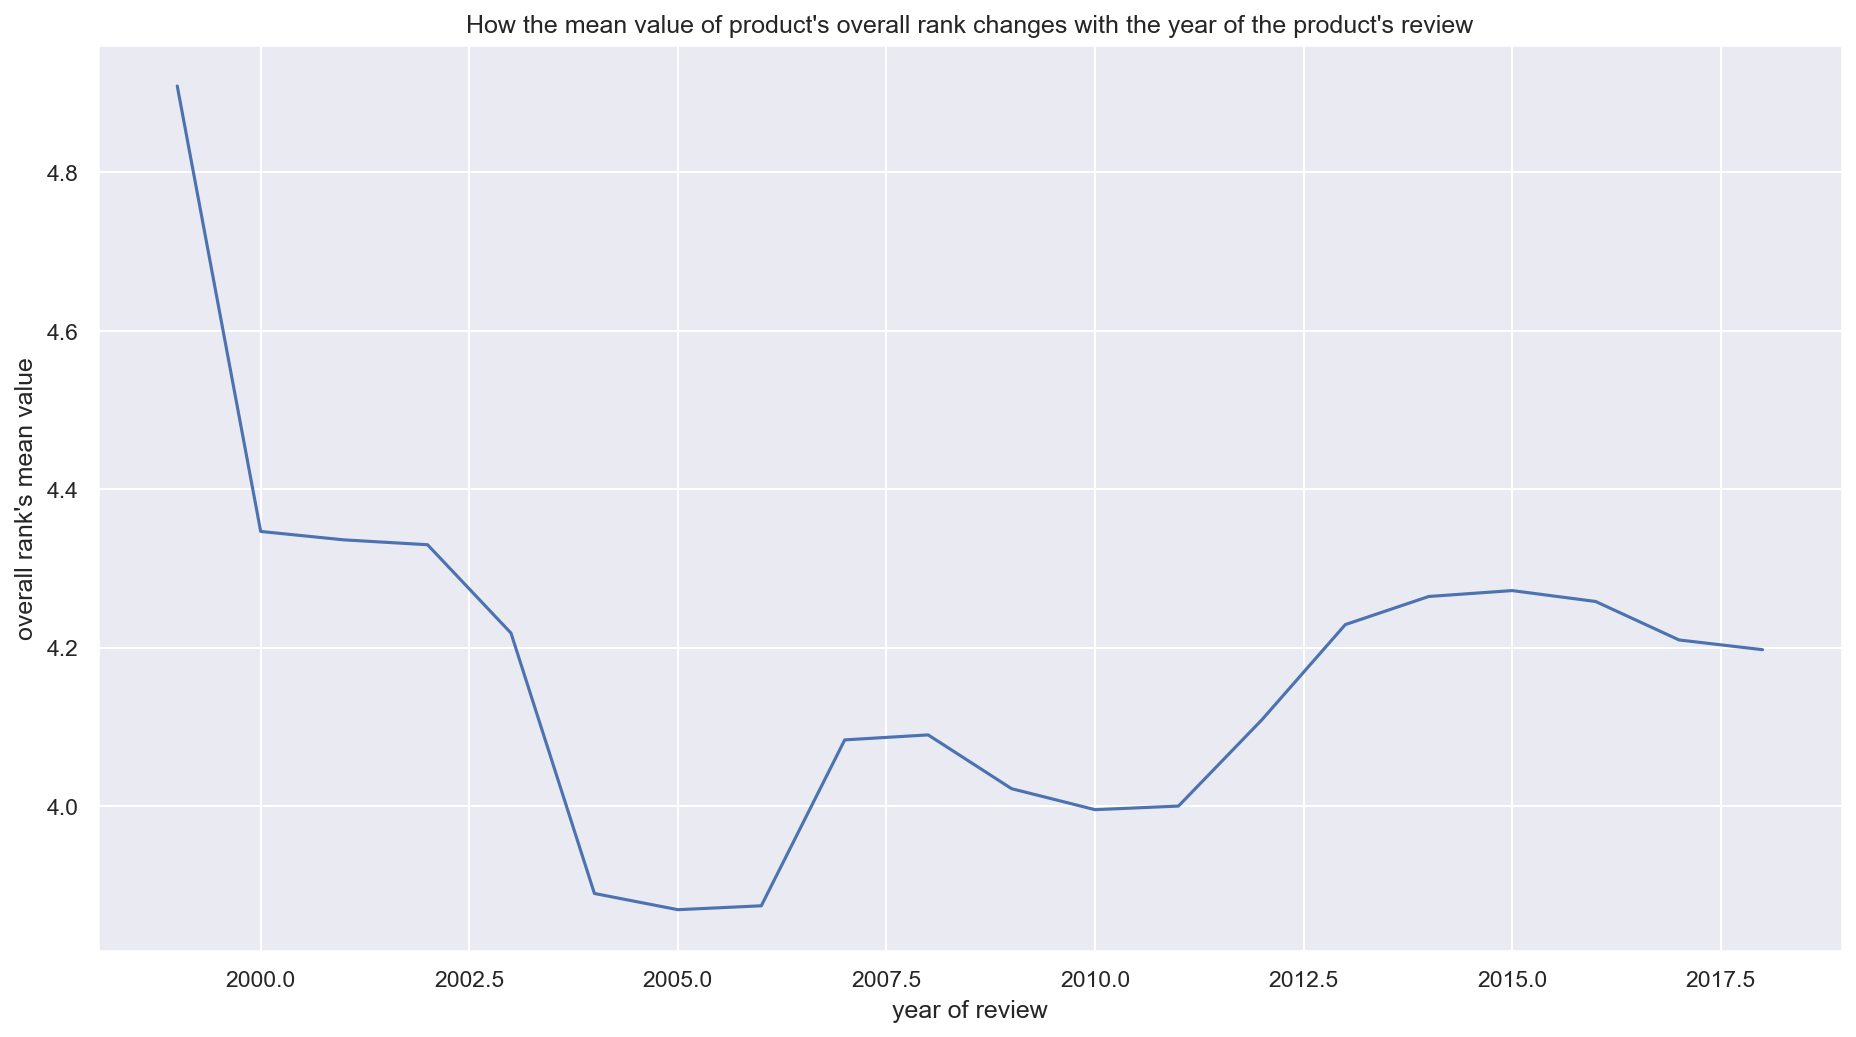

In [30]:
review_year_overall = review_data.groupby(['reviewYear'])['overall'].mean()
review_year_overall = review_year_overall.reset_index()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='reviewYear',y='overall',data=review_year_overall)
ax.set_title("How the mean value of product's overall rank changes with the year of the product's review")
ax.set_ylabel("overall rank's mean value")
ax.set_xlabel('year of review')

#### Distribution of total Number of Reviews made by Each User
Both the bar plot and box plot suffer from overplotting and we can observe that there is some extreme outliers of total number of purchase. We may suspect that those number comes from some top reviewers or some fake reviews. After we restricted total number of purchase to be less than or equal to 25, we may see that the number of users decreases as the number of purchase increases. Most users only purchase once or twice. 

Text(0.5, 0, 'Total Number of Reviews')

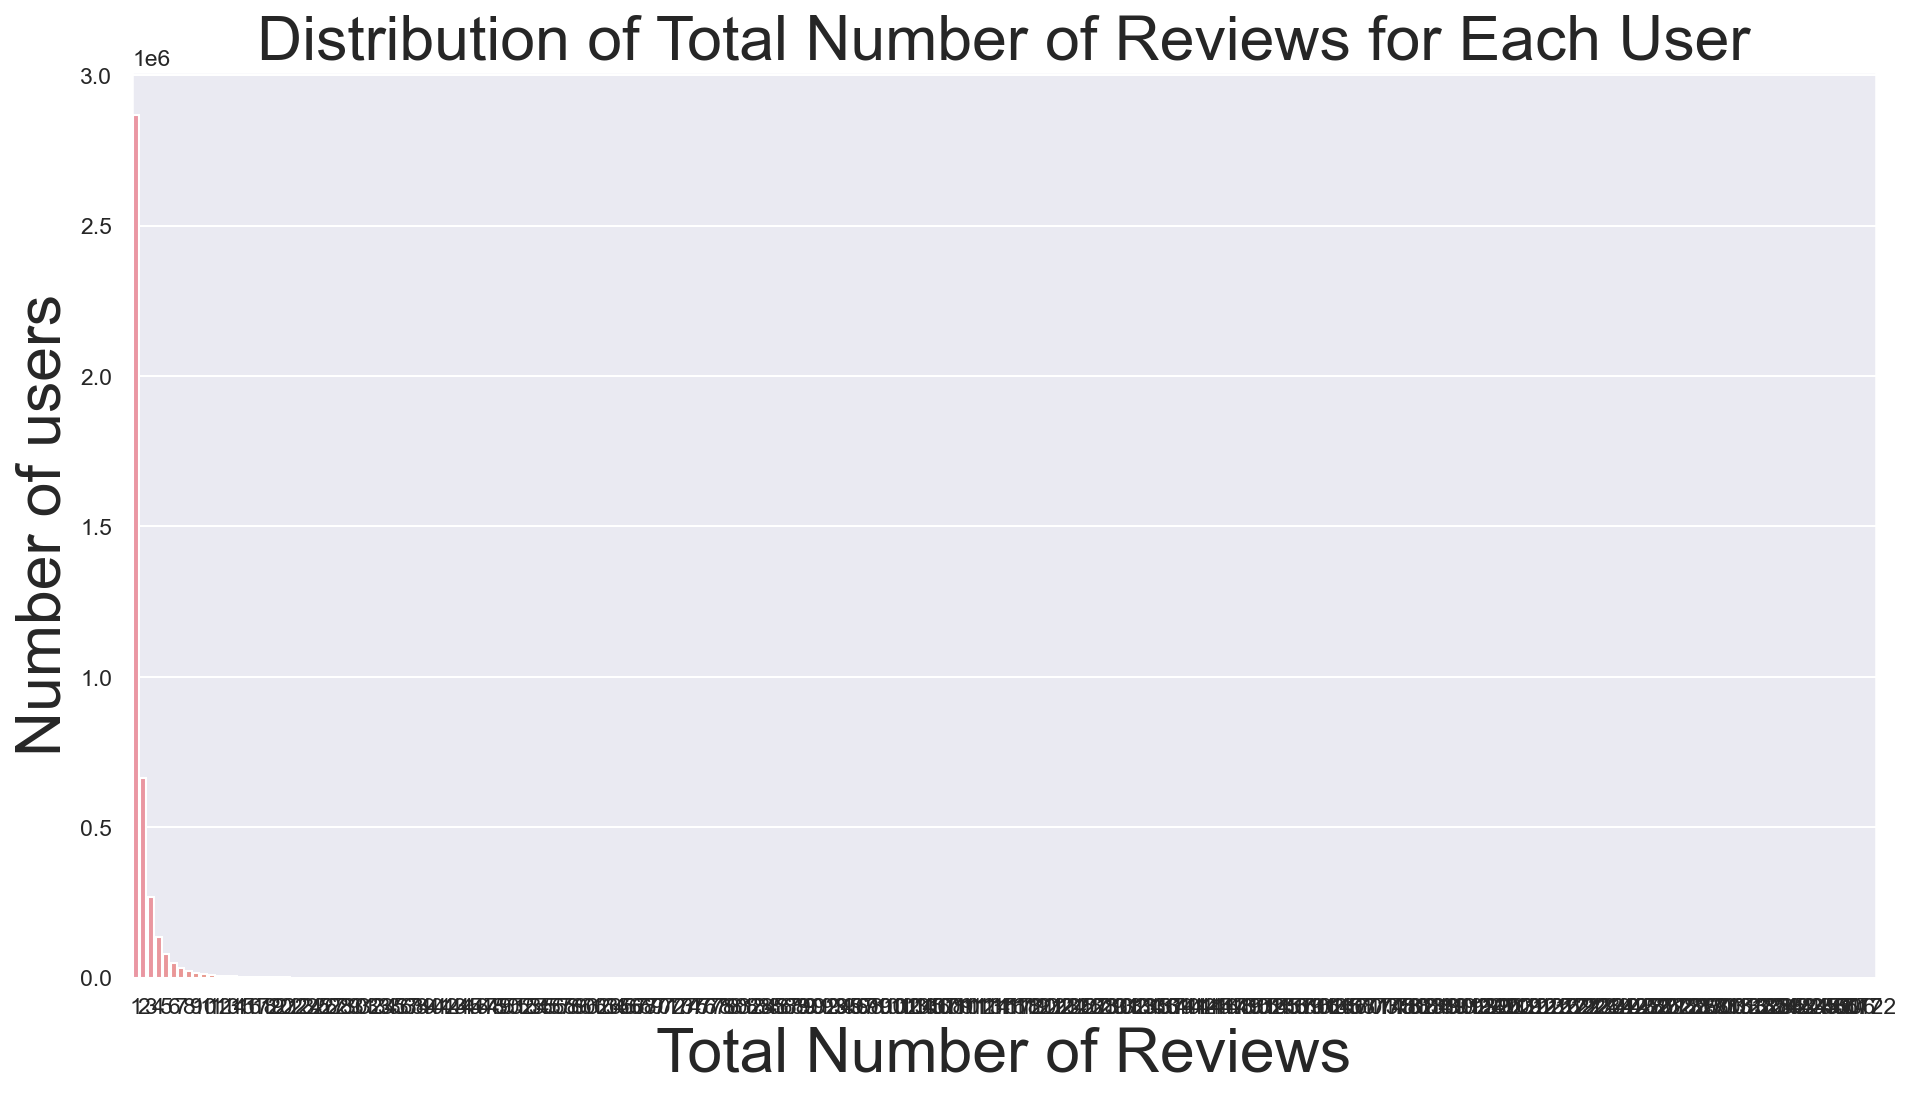

In [35]:
num_of_purchase = review_data[['reviewerID', 'overall']].groupby('reviewerID').count()
plt.figure(figsize=(15,8))
ax = sns.countplot(x=num_of_purchase["overall"])
ax.set_title("Distribution of Total Number of Reviews for Each User", fontsize=30)
ax.set_ylabel("Number of users", fontsize=30)
ax.set_xlabel("Total Number of Reviews", fontsize=30)

Text(0.5, 0, 'Total Number of Reviews')

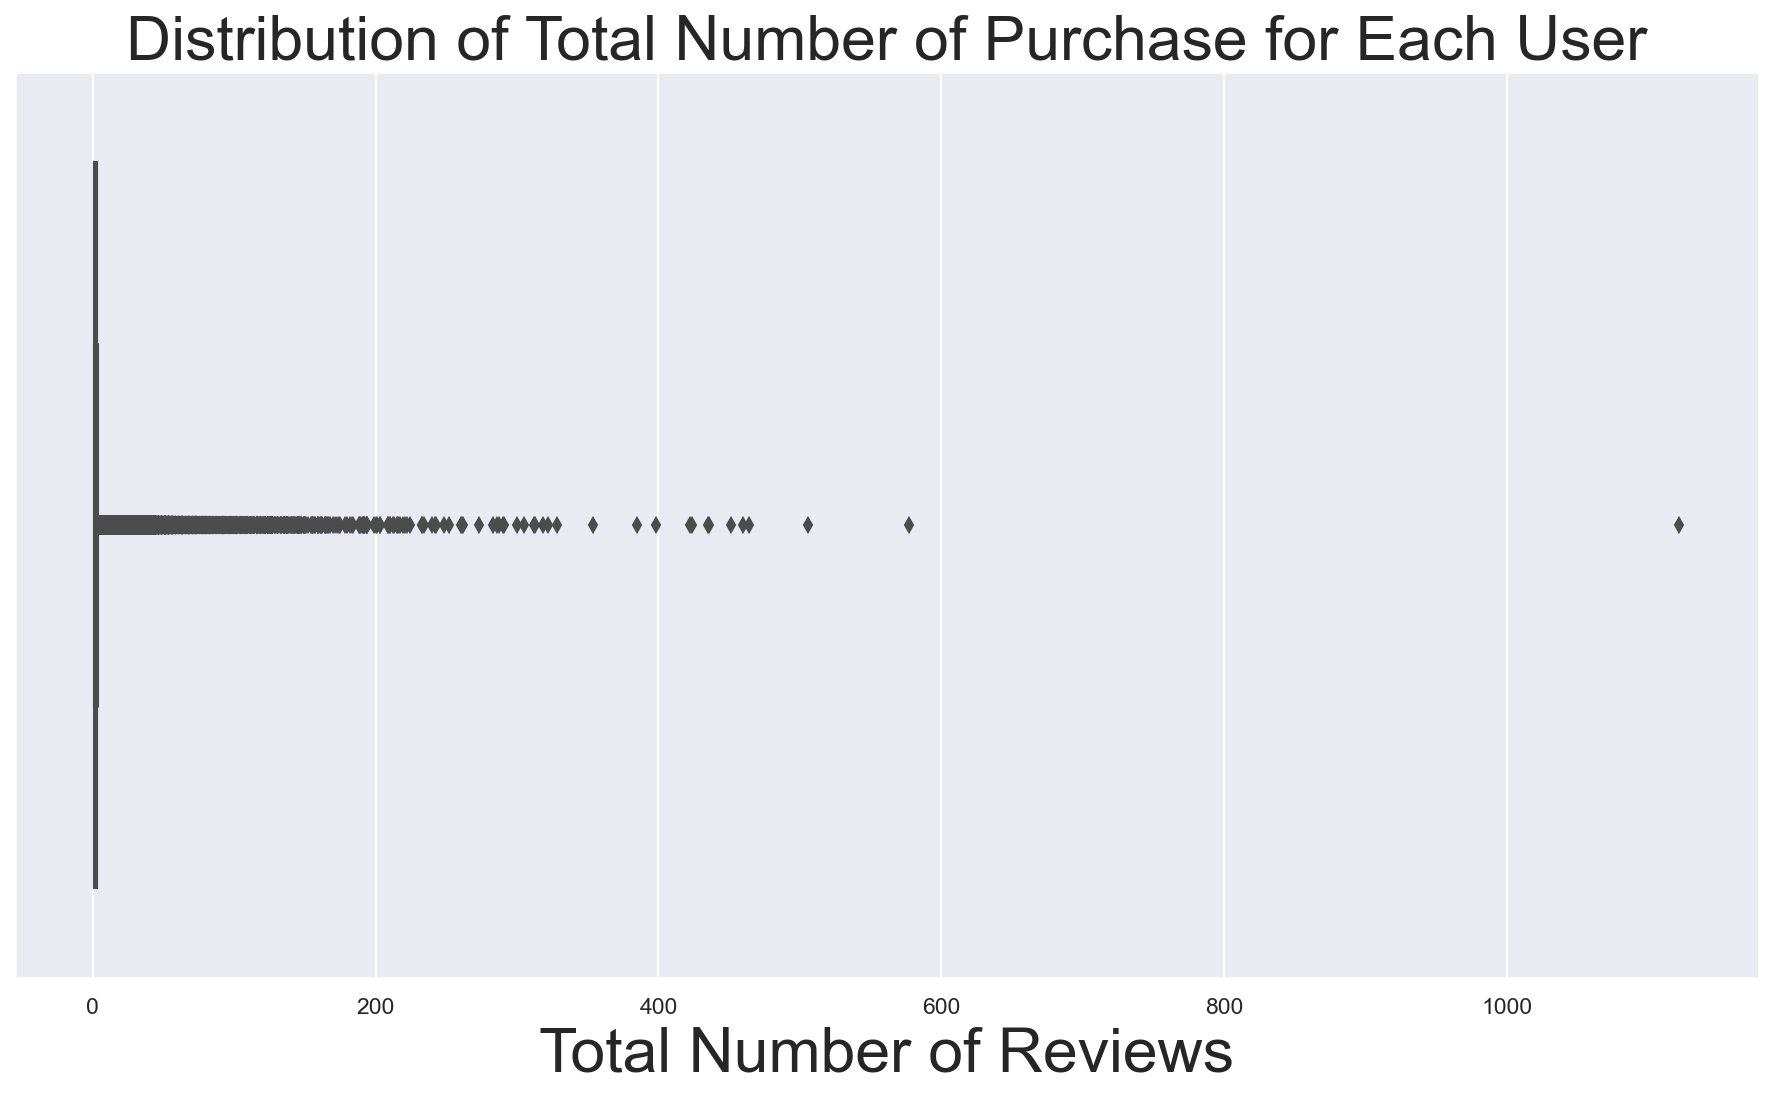

In [36]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x=num_of_purchase["overall"])
ax.set_title("Distribution of Total Number of Purchase for Each User", fontsize=30)
ax.set_xlabel("Total Number of Reviews", fontsize=30)

In [37]:
num_of_purchase.describe()

,overall
count,4.204772e+06
mean,1.903096e+00
std,3.096718e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.122000e+03


In [38]:
num_of_purchase_less = num_of_purchase[num_of_purchase['overall'] <= 25]

Text(0.5, 0, 'Total Number of Reviews')

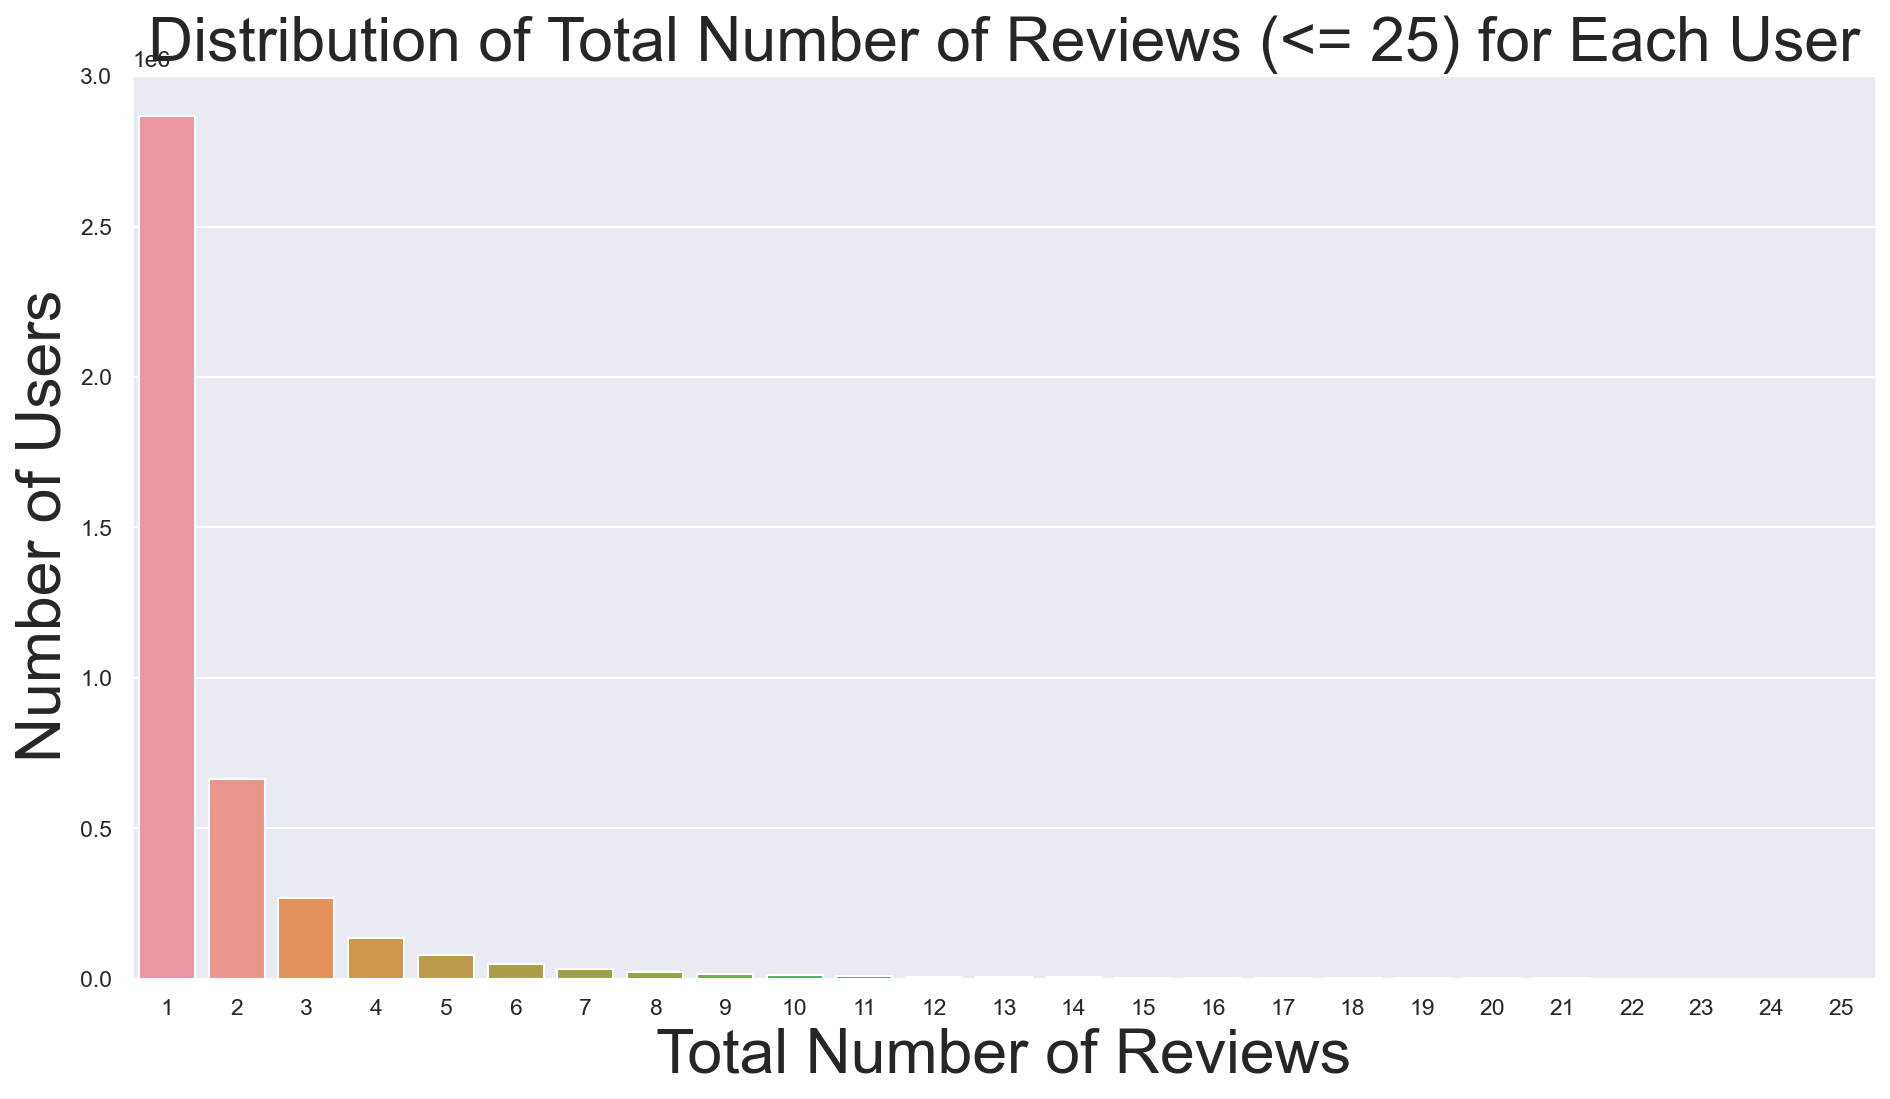

In [39]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=num_of_purchase_less["overall"])
ax.set_title("Distribution of Total Number of Reviews (<= 25) for Each User", fontsize=30)
ax.set_ylabel("Number of Users", fontsize=30)
ax.set_xlabel("Total Number of Reviews", fontsize=30)

#### Distribution of Average Rating of Purchases for Each User
Surprisingly, we can observe that a significant number of people give an average rating of 5 for their purchases. Fewer people give an average rating of 4. Least number of users give an average rating of 2.

Text(0.5, 0, 'Average Rating')

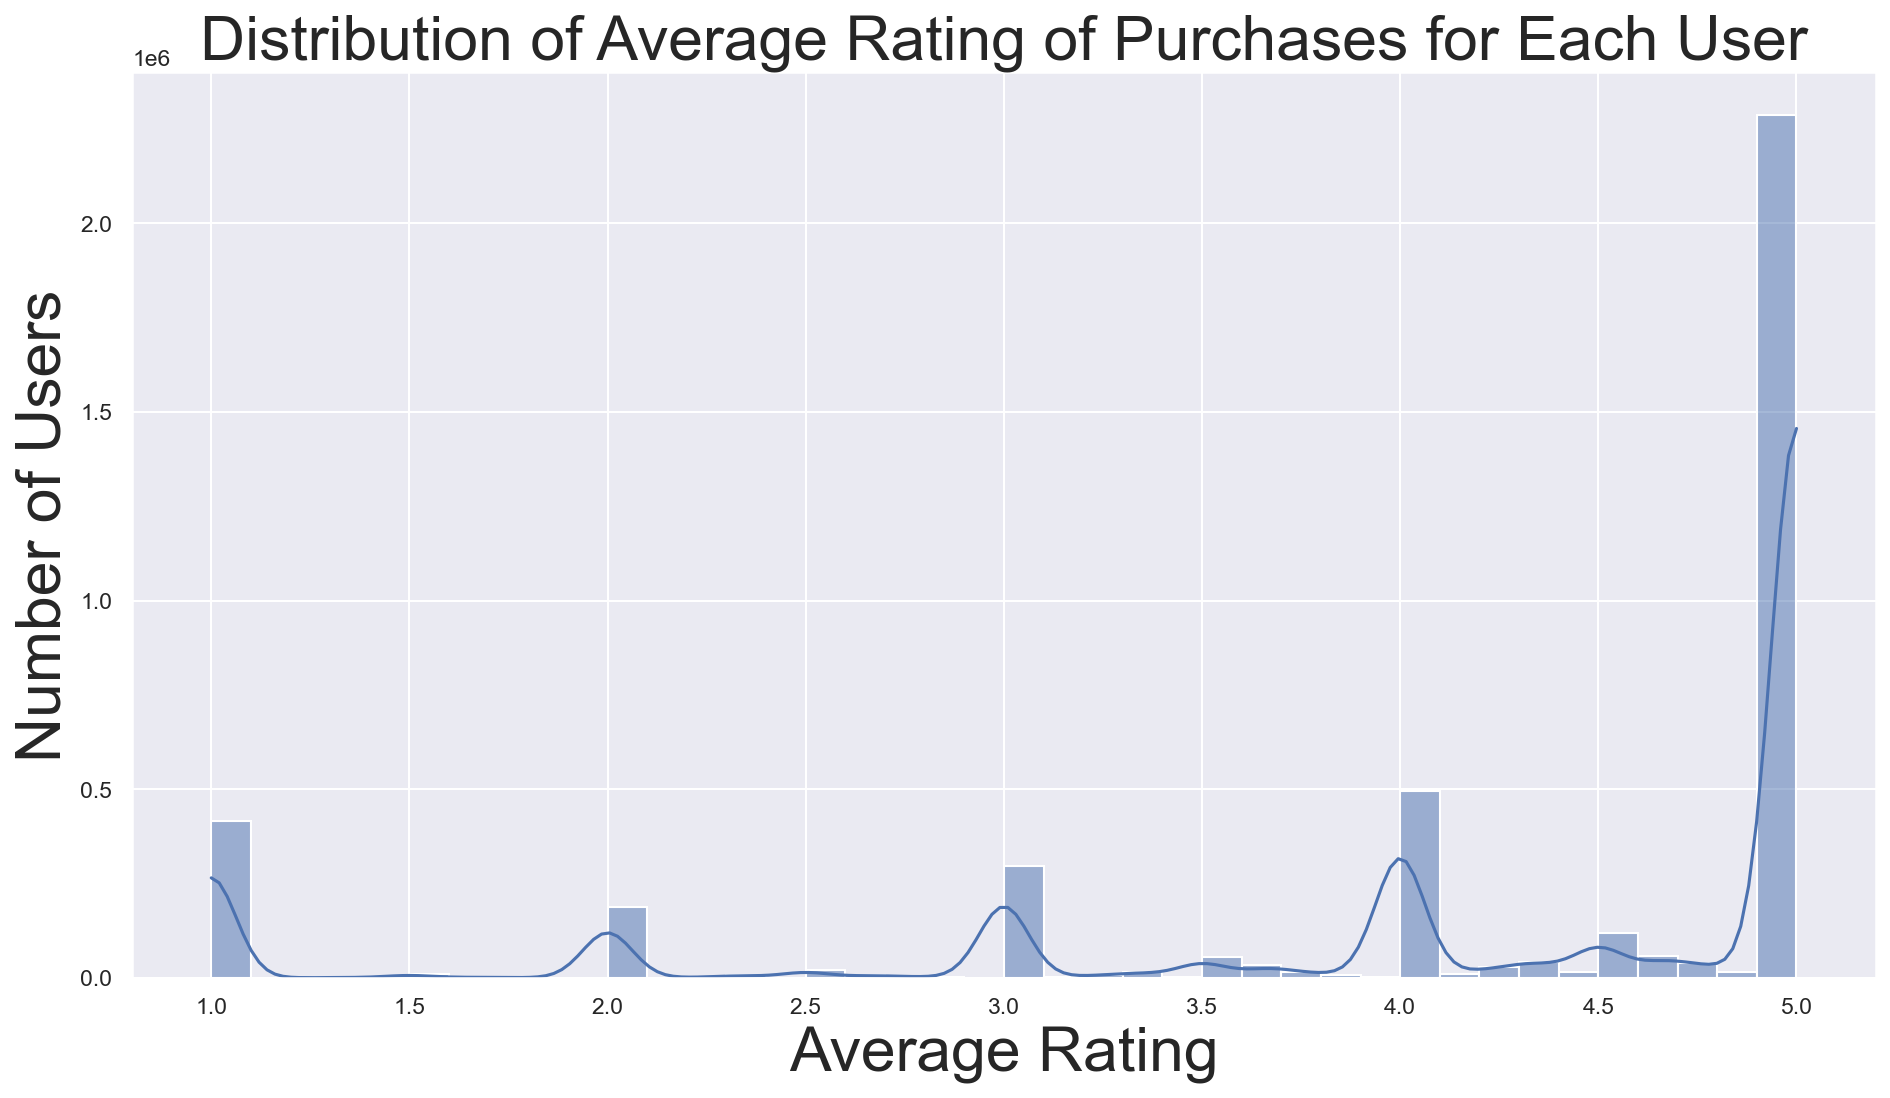

In [40]:
avg_of_rating = review_data[['reviewerID', 'overall']].groupby('reviewerID').mean()
plt.figure(figsize=(15,8))
ax = sns.histplot(x='overall', data=avg_of_rating, bins=40, kde=True)
ax.set_title("Distribution of Average Rating of Purchases for Each User", fontsize=30)
ax.set_ylabel("Number of Users", fontsize=30)
ax.set_xlabel("Average Rating", fontsize=30)

#### Number of purchases for each product

As we mentioned before, there should be one review for each purchase. From the histgram below, almost all of the product have only one review. However, there are still some outliers which have 2 piece of reviews. This can help explain why we have to remove duplicate pruchases(reviews) from our raw data. 

In [7]:
number_of_purchases = meta_data.groupby('asin').size()
number_of_products = len(number_of_purchases)
number_of_purchases.describe()

count    624284.000000
mean          1.015376
std           0.123043
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
dtype: float64

Text(0, 0.5, 'Number of purchases')

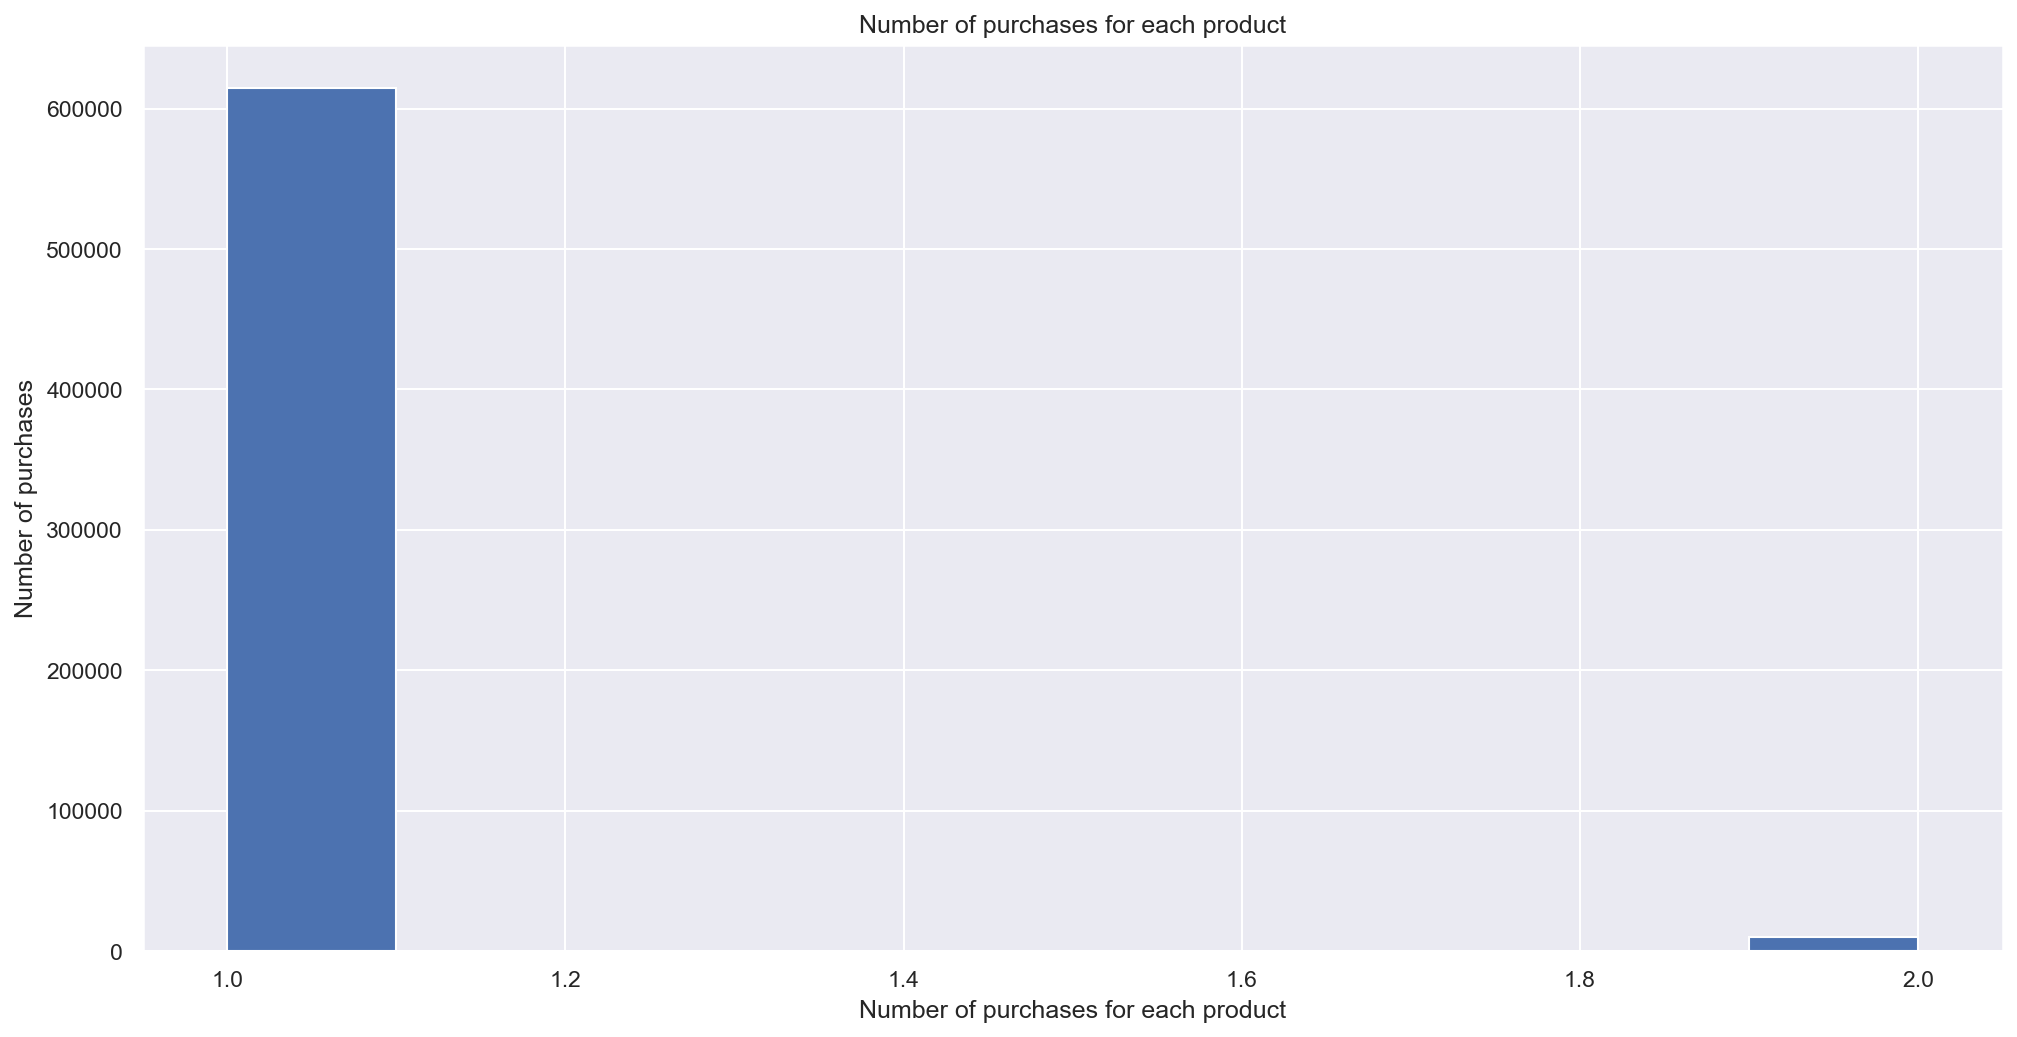

In [8]:
plt.hist(number_of_purchases)
plt.title('Number of purchases for each product')
plt.xlabel('Number of purchases for each product')
plt.ylabel('Number of purchases')

#### Number of rating for each product

For first glance of our data, we can observe that almost all of the products have the number of rating less than 1000. Then we do several attempted filtering, we found out that when we only keep the products whose number of rating is less than 200. From our filtered histgram, we can find out that for most of products, the total number of ratings is less than 25. And only few of them have more than 200 ratings.

In [10]:
NumberOfRating = review_data.groupby('asin').size()
NumberOfRating.describe()

count    624792.000000
mean         13.126338
std          66.866361
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       12680.000000
dtype: float64

Text(0, 0.5, 'Number of products')

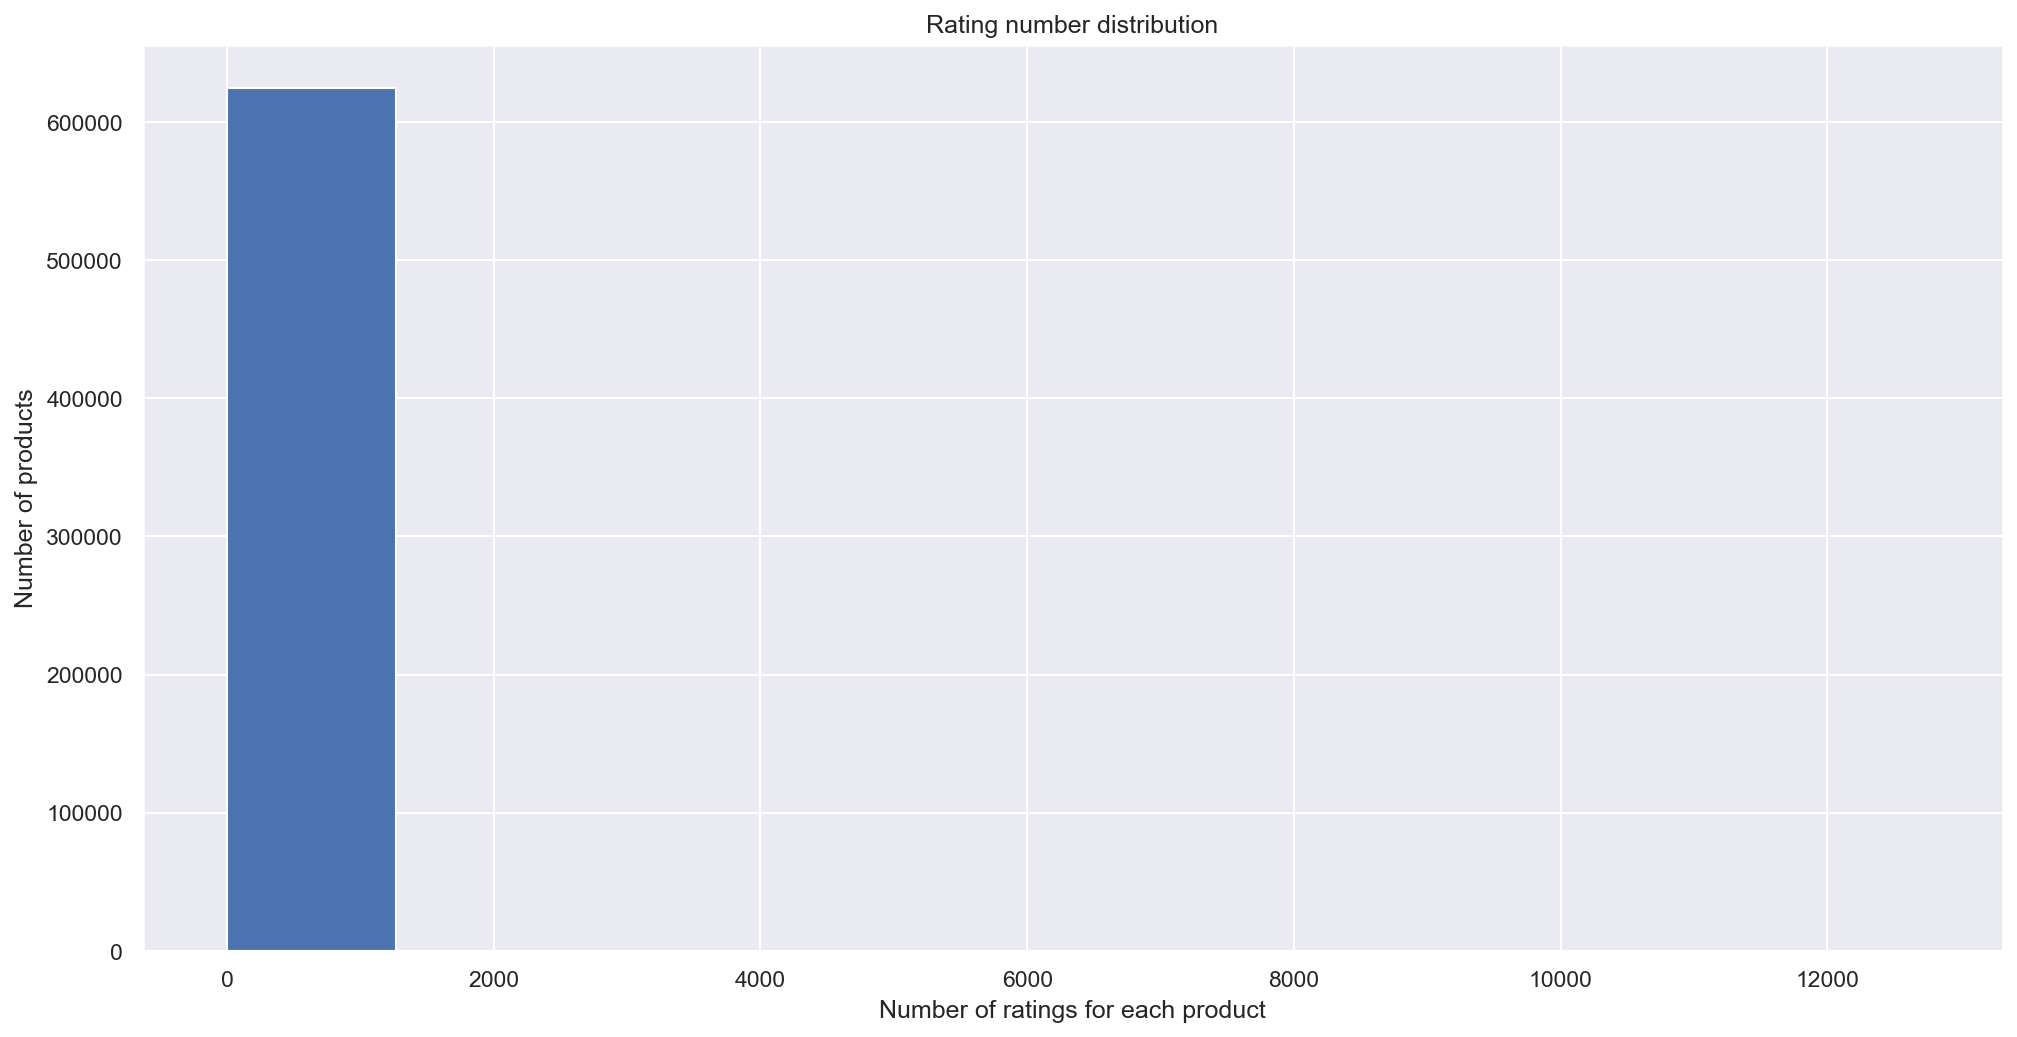

In [17]:
# Number of purchases for each product
plt.hist(NumberOfRating)
plt.title('Rating number distribution')
plt.xlabel('Number of ratings for each product')
plt.ylabel('Number of products')

Filter (< 200)

Text(0, 0.5, 'Number of products')

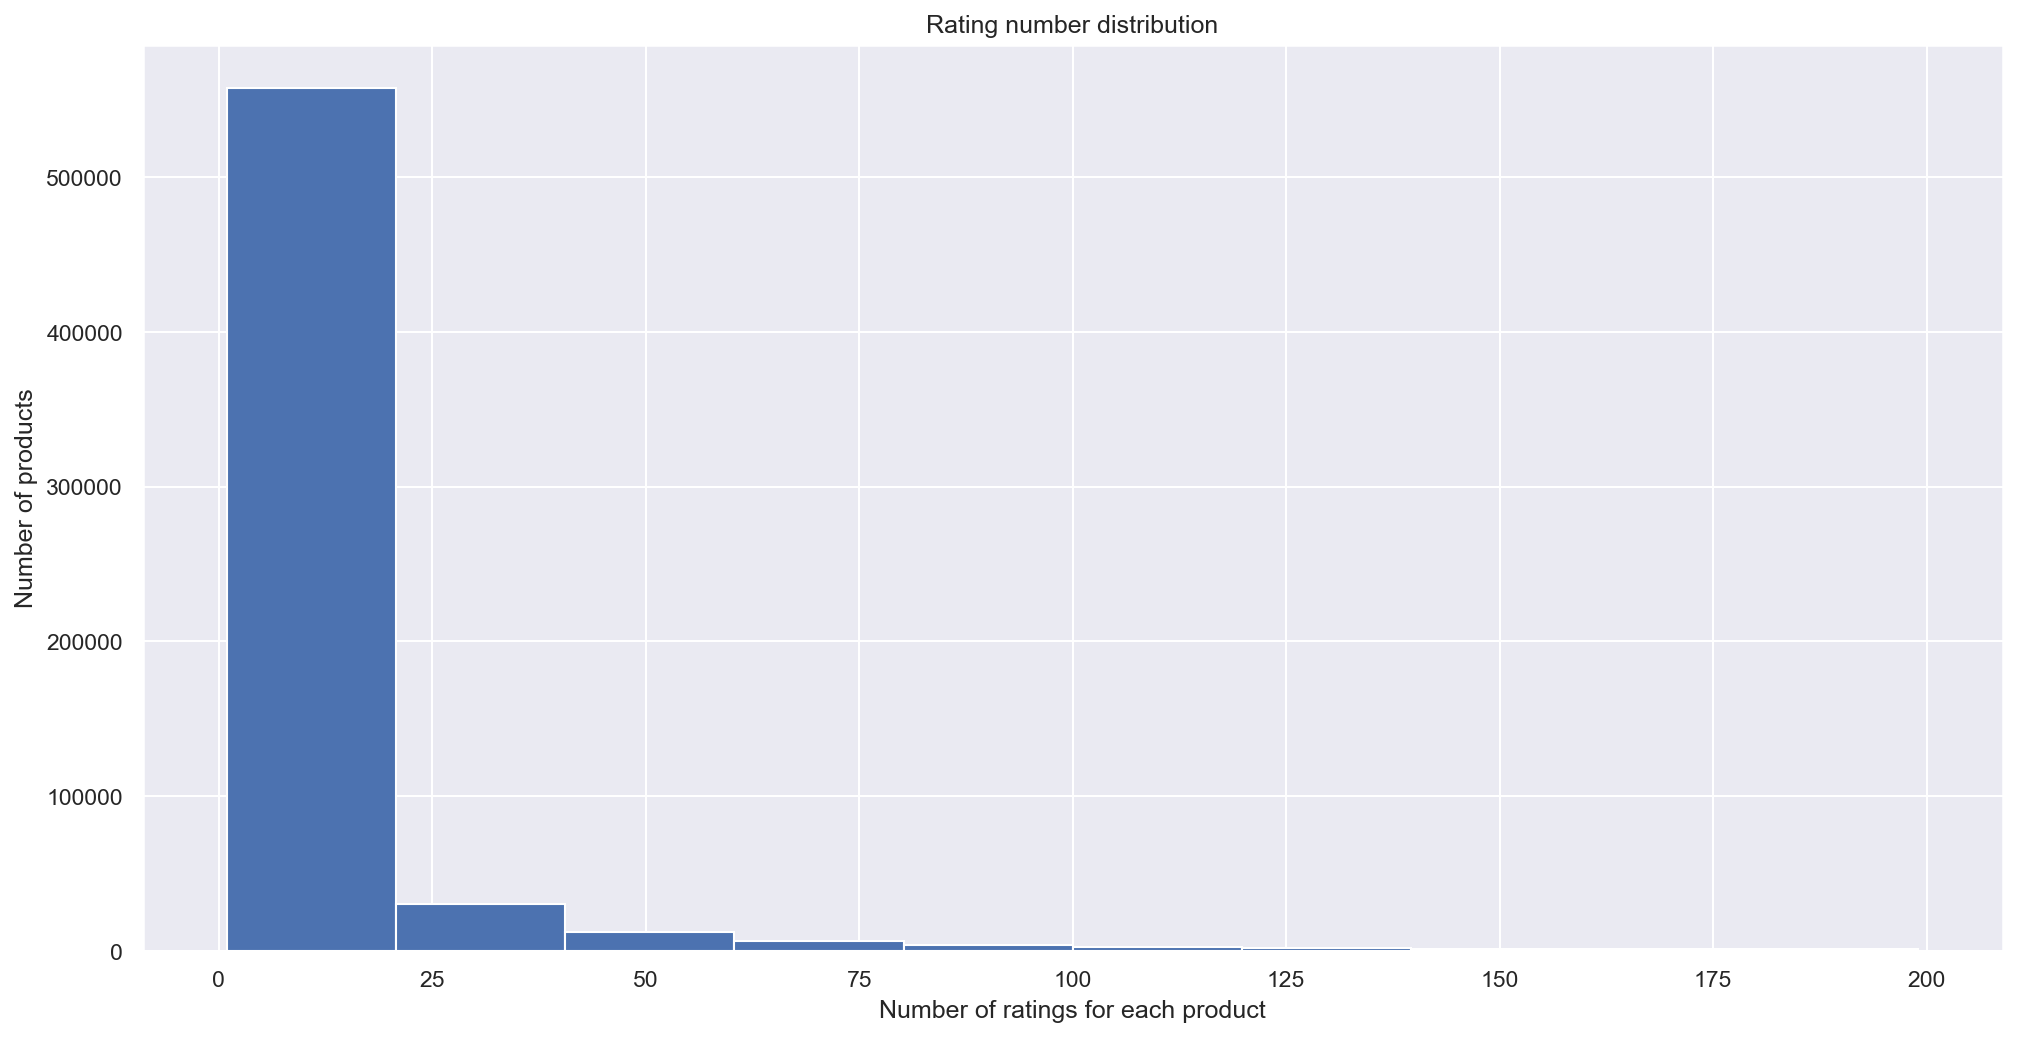

In [18]:
NumberOfRating1 = NumberOfRating[NumberOfRating < 200]
plt.hist(NumberOfRating1)
plt.title('Rating number distribution')
plt.xlabel('Number of ratings for each product')
plt.ylabel('Number of products')

Filter (< 25)

Text(0, 0.5, 'Number of products')

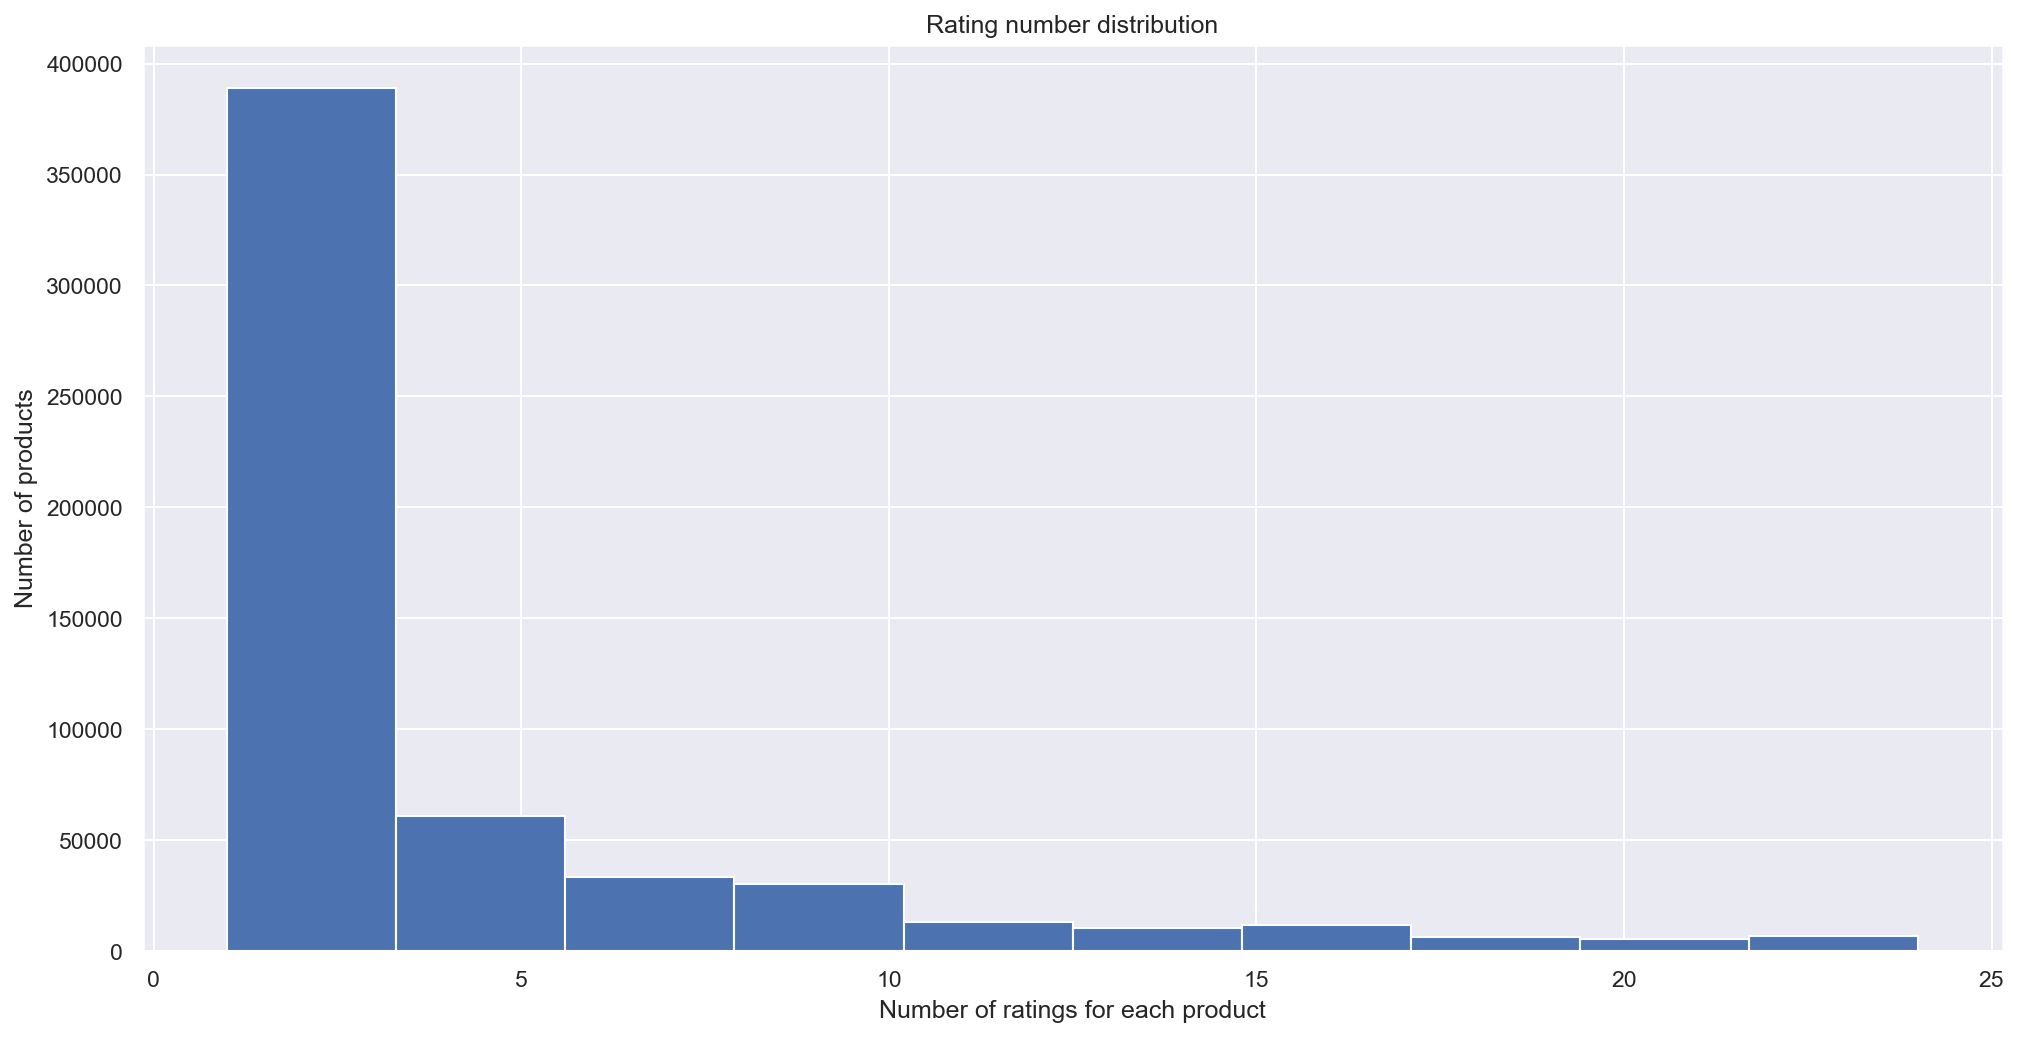

In [19]:
NumberOfRating2 = NumberOfRating[NumberOfRating < 25]
plt.hist(NumberOfRating2)
plt.title('Rating number distribution')
plt.xlabel('Number of ratings for each product')
plt.ylabel('Number of products')

#### Linear regression
We want to find out whether it is possible to predict the overall rank of a product using review length, product's price and the year of the review. The process is the following:

In [43]:
# prepare data for linear regression model
df_all_dummy = pd.get_dummies(all_data, columns=['reviewYear'])

In [44]:
# build the linear regression model
X = df_all_dummy[['review_length', 'price', 'reviewYear_1999',
                   'reviewYear_2000', 'reviewYear_2001', 'reviewYear_2002',
                   'reviewYear_2003', 'reviewYear_2004', 'reviewYear_2005',
                   'reviewYear_2006', 'reviewYear_2007', 'reviewYear_2008',
                   'reviewYear_2009', 'reviewYear_2010', 'reviewYear_2011',
                   'reviewYear_2012', 'reviewYear_2013', 'reviewYear_2014',
                   'reviewYear_2015', 'reviewYear_2016', 'reviewYear_2017',
                   'reviewYear_2018']]
y = df_all_dummy[['overall']]
reg = LinearRegression(fit_intercept = False).fit(X, y)

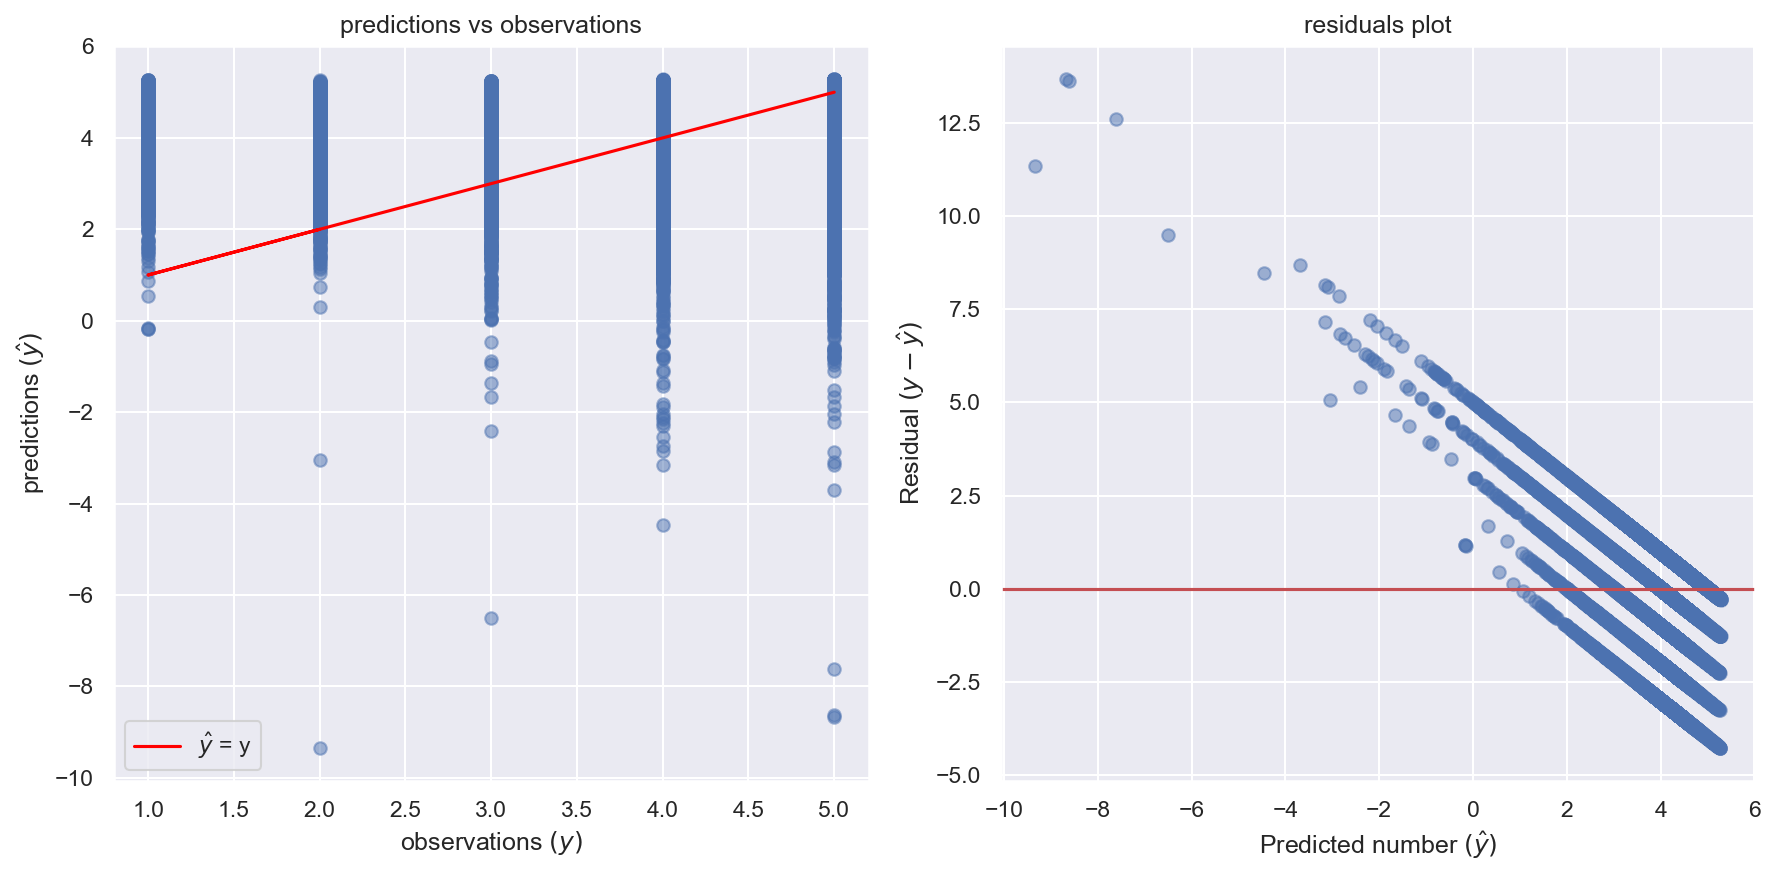

In [45]:
# analyze with plots
y_predict = reg.predict(X)
plt.figure(figsize=(12,6))      # do not change this line

plt.subplot(121)                # do not change this line
# (1) predictions vs observations

plt.scatter(y, y_predict, alpha=0.5)
y_cpy = np.array(y.copy())
y_cpy = y_cpy[(max(y_predict) > y_cpy) &  (min(y_predict) < y_cpy)]
plt.plot(y_cpy, y_cpy, color = 'red', label = '$\hat{y}$ = y')
plt.title('predictions vs observations')
plt.xlabel('observations $(y)$')
plt.ylabel('predictions $(\hat{y})$')
plt.legend()

plt.subplot(122)               # do not change this line
# (2) residual plot
plt.scatter(y_predict, y - y_predict, alpha=0.5)
plt.axhline(y = 0, color='r');
plt.title('residuals plot')
plt.xlabel("Predicted number $(\hat{y})$")
plt.ylabel("Residual $(y - \hat{y})$")

plt.tight_layout()             # do not change this line

From the first plot, we could find that for overall rank < 2.5, most of the points are overestimated(points scattered above the red line), while for overall rank > 3.5, most of the points are underestimated(points scattered below the red line). From the second plot, we could find that there is a clear pattern without a similar vertical spread throughout the entire plot. Hence, the accuracy of the predictions is not reliable.

We also compute the **Multiple $R^2$** metric
$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

In [46]:
r2 = np.var(y_predict) / np.var(y)
r2

overall    0.012513
dtype: float64

From the **Multiple $R^2$** metric, we can also find that our linear regression model performs poorly. It only explains 1.2513% of the variance in the true y.

Therefore, we need another better model or add more features to predict the product's overall rank.